In [1]:
!pip install matminer
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html
!pip install matgl

import matgl
matgl.set_backend("DGL")

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html


In [2]:
from pymatgen.core import Lattice, Structure

model = matgl.load_model("MEGNet-MP-2018.6.1-Eform")

# This is the structure obtained from the Materials Project.
struct = Structure.from_spacegroup("Pm-3m", Lattice.cubic(4.1437), ["Cs", "Cl"], [[0, 0, 0], [0.5, 0.5, 0.5]])
eform = model.predict_structure(struct)
print(f"The predicted formation energy for CsCl is {float(eform.numpy()):.3f} eV/atom.")

The predicted formation energy for CsCl is -2.272 eV/atom.


/usr/local/lib/python3.12/dist-packages/matgl/utils/io.py:159: UserWarning: Incompatible model version detected! The code will continue to load the model but it is recommended that you provide a path to an updated model, increment your @model_version in model.json if you are confident that the changes are not problematic, or clear your ~/.matgl cache using `python -c "import matgl; matgl.clear_cache()"`
  _check_ver(cls_, v)  # Check version of any subclasses too.
/usr/local/lib/python3.12/dist-packages/dgl/readout.py:443: DGLWarning: For a single graph, use a tensor of shape (1, *) for graph_feat. The support of shape (*) will be deprecated.
  dgl_warning(


In [3]:
#!pip install "numpy<2"
#!pip install dgl==2.2.0
#!pip install torch==2.3.0
#!pip install "torchdata<=0.8.0"
!pip install xgboost
!pip install catboost
#!pip install matgl

In [4]:
import torch
from pymatgen.core import Lattice, Structure

struct = Structure.from_spacegroup("Pm-3m", Lattice.cubic(4.1437), ["Cs", "Cl"], [[0, 0, 0], [0.5, 0.5, 0.5]])
model = matgl.load_model("MEGNet-MP-2019.4.1-BandGap-mfi")

In [5]:
# Load the pre-trained M3GNet formation energy model
model = matgl.load_model("M3GNet-MP-2018.6.1-Eform")
eform = model.predict_structure(struct)
print(f"The predicted formation energy for CsCl is {float(eform):.3f} eV/atom.")

# Extract the structure features of a structure
feat_dict = model.model.predict_structure(struct, return_features=True)
# Print out structure-wise features, it should be the dimension of node_features * 2 from set2set layer
print(feat_dict["readout"].shape)



The predicted formation energy for CsCl is -2.220 eV/atom.
torch.Size([1, 128])


In [6]:
import pandas as pd
import numpy as np
import plotly as pt
import seaborn as sns
#!pip install pymatgen
!pip install mp_api
import requests
import json
import matplotlib.pyplot as plt


#Initialization

In [7]:
#Input
cif_folder = "/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/"
dataset_from_google_drive = True

#Augmentation
do_augmentation = True

#Outliers
remove_outliers = True
remove_outliers_manually = True
remove_outliers_after_descriptors = False

#Normalization vs Standartization
normalization_type =  'Stand' #'Stand' #'Norm'
log_transform = False

#CIFs
extract_CIFs = False
update_IDs = False  #request material IDs from databases
embedding_type = 'None' #   'None',  'SiteStatsFingerprint' , 'M3GNet', 'RDF', 'CGCNN', 'electronic_RDF'

#Feature selection
do_PCA = False
do_PCA_on_embeddings_only = True
do_LASSO = False
manual_features = True

#ML
stratification = True
non_uniform_stratification = False

target_col = 'Log_rate'
finite_log_of_zero_rate = False
cross_validation = False
grid_search = False


In [8]:

df = None
if(dataset_from_google_drive):
  df = pd.read_excel("/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/Perovskite dataset export.xlsx",sheet_name='Photocatalytic dataset')
else:
  df = pd.read_excel("dataset.xlsx")

In [9]:
df

Perovskite       Class   Hill formula Interlayer space composition  \
0       K4Nb6O17    K4Nb6O17     K4 Nb6 O17                          NaN   
1       KLaNb2O7    HLaNb2O7    K La Nb2 O7                          NaN   
2      RbLaNb2O7    HLaNb2O7   La Nb2 O7 Rb                          NaN   
3      CsLaNb2O7    HLaNb2O7   Cs La Nb2 O7                          NaN   
4     KCa2Nb3O10  KCa2Nb3O10  Ca2 K Nb3 O10                          NaN   
...          ...         ...            ...                          ...   
1084        TiO2       oxide            NaN                          NaN   
1085        TiO2       oxide            NaN                          NaN   
1086        TiO2       oxide            NaN                          NaN   
1087        TiO2       oxide            NaN                          NaN   
1088        TiO2       oxide            NaN                          NaN   

      Bandgap, eV                        DOI Materials Project ID   COD_ID  \
0            3.50         10.1007/BF00765319            mp-560692  1001842   
1            3.20         10.1007/BF00765319           mp-1223501  1545643   
2            3.35         10.1007/BF00765319            mp-553965       -1   
3            3.30         10.1007/BF00765319            mp-553248  2004917   
4            3.35         10.1007/BF00765319            mp-557195  1521061   
...           ...                        ...                  ...      ...   
1084         3.20  10.1134/S107036321404001X           mp-1245098  1010942   
1085         3.20  10.1134/S107036321404001X           mp-1245098  1010942   
1086         3.20  10.1134/S107036321404001X           mp-1245098  1010942   
1087         3.20  10.1134/S107036321404001X           mp-1245098  1010942   
1088         3.20  10.1134/S107036321404001X           mp-1245098  1010942   

     Springer_ID MP_CIF_modifier  ... CatW, g/L Alcohol, %  Sac Agent 1  \
0            NaN             NaN  ...      2.85       14.3            -   
1            NaN             NaN  ...      2.85       14.3            -   
2            NaN             NaN  ...      2.85       14.3            -   
3            NaN             NaN  ...      2.85       14.3            -   
4            NaN             NaN  ...      2.85       14.3            -   
...          ...             ...  ...       ...        ...          ...   
1084         NaN             NaN  ...      1.00        0.1            -   
1085         NaN             NaN  ...      1.00        0.1            -   
1086         NaN             NaN  ...      1.00        0.1            -   
1087         NaN             NaN  ...      1.00        0.1            -   
1088         NaN             NaN  ...      1.00        0.1            -   

      Sac agent 2  Light type  Power, W Wave length min, nm Cell material  \
0               -     Hg lamp     450.0                 NaN           NaN   
1               -     Hg lamp     450.0                 NaN           NaN   
2               -     Hg lamp     450.0                 NaN           NaN   
3               -     Hg lamp     450.0                 NaN           NaN   
4               -     Hg lamp     450.0                 NaN           NaN   
...           ...         ...       ...                 ...           ...   
1084            -     Hg lamp     125.0               220.0        quartz   
1085            -     Hg lamp     125.0               220.0        quartz   
1086            -     Hg lamp     125.0               220.0        quartz   
1087            -     Hg lamp     125.0               220.0        quartz   
1088            -     Hg lamp     125.0               220.0        quartz   

     Temperature, K  Rate, umol/(g*h)  
0               NaN        130.000000  
1               NaN         28.000000  
2               NaN         60.000000  
3               NaN         12.000000  
4               NaN         14.000000  
...             ...               ...  
1084          288.0         38.181818  
1085      

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 89 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Perovskite                            1089 non-null   object 
 1   Class                                 846 non-null    object 
 2   Hill formula                          730 non-null    object 
 3   Interlayer space composition          5 non-null      object 
 4   Bandgap, eV                           1054 non-null   float64
 5   DOI                                   1084 non-null   object 
 6   Materials Project ID                  1058 non-null   object 
 7   COD_ID                                935 non-null    object 
 8   Springer_ID                           257 non-null    object 
 9   MP_CIF_modifier                       510 non-null    object 
 10  COD_CIF_modifier                      197 non-null    object 
 11  Springer_CIF_modi

In [11]:
df.describe()

Bandgap, eV           Z        Z_MP       Z_COD  Z_Springer  \
count  1054.000000  694.000000  832.000000  836.000000  836.000000   
mean      3.313241    2.275216    1.260817    1.281100    0.151715   
std       0.644047    1.762830    3.460696    2.116075    0.642689   
min       0.010000    0.333333    0.000000    0.000000    0.000000   
25%       3.100000    1.000000    0.000000    0.000000    0.000000   
50%       3.410000    2.000000    0.000000    0.000000    0.000000   
75%       3.600000    4.000000    1.000000    2.000000    0.000000   
max       5.500000   16.000000   50.000000   16.000000    4.000000   

              d,A        a_MP        b_MP        c_MP       a_COD  ...  \
count  810.000000  827.000000  354.000000  354.000000  832.000000  ...   
mean    14.386401    3.084536    7.406617   14.790353    3.040421  ...   
std      7.950408    4.236046    3.399894    8.264087    6.154639  ...   
min      0.000000    0.000000    3.840000    3.904344    0.000000  ...   
25%     11.185000    0.000000    3.950634   10.502783    0.000000  ...   
50%     14.733000    0.000000    7.415443   12.879040    0.000000  ...   
75%     17.850000    5.801718    7.938952   15.513552    3.899000  ...   
max     38.670000   22.855297   20.551678   48.809404   41.857000  ...   

       Oxygen_concentration avg  Packing fraction avg     CalcT(K)  \
count                832.000000            832.000000  1010.000000   
mean                        inf              0.238767  1287.020792   
std                         NaN              0.257556   222.542464   
min                    0.000000              0.000000   453.000000   
25%                    0.037279              0.000000  1223.000000   
50%                    0.042938              0.000000  1373.000000   
75%                    0.046684              0.533675  1423.000000   
max                         inf              0.657822  1873.000000   

       Calc time (h)   CatW, g/L  Alcohol, %     Power, W  \
count     973.000000  987.000000  966.000000   994.000000   
mean       19.338386    1.428618    5.628230   306.726358   
std        25.264723    1.324191    8.781436   198.606250   
min         0.000000    0.000000    0.000000   100.000000   
25%        10.000000    0.500000    0.000000   125.000000   
50%        12.000000    1.000000    1.000000   300.000000   
75%        24.000000    2.000000   10.000000   450.000000   
max       200.000000   10.000000   90.000000  1000.000000   

       Wave length min, nm  Temperature, K  Rate, umol/(g*h)  
count           689.000000      540.000000        989.000000  
mean            288.388970      294.435185       6914.999659  
std              88.814702       13.175195      21648.175384  
min             200.000000      288.000000          0.000000  
25%             220.000000      288.000000         15.500000  
50%             220.000000      288.000000        166.000000  
75%             400.000000      293.000000       1680.000000  
max             660.000000      333.000000     156000.000000  

[8 rows x 55 columns]

In [12]:
df.columns

Index(['Perovskite', 'Class', 'Hill formula', 'Interlayer space composition',
       'Bandgap, eV', 'DOI', 'Materials Project ID', 'COD_ID', 'Springer_ID',
       'MP_CIF_modifier', 'COD_CIF_modifier', 'Springer_CIF_modifier',
       'Materials Project verification', 'COD verification',
       'Springer verification', 'General verification', 'MP_CIF_modified',
       'COD_CIF_modified', 'Springer_CIF_modified', 'Z', 'Z_MP', 'Z_COD',
       'Z_Springer', 'a, A', 'b, A', 'c, A', 'Symmetry group', 'd,A', 'a_MP',
       'b_MP', 'c_MP', 'a_COD', 'b_COD', 'c_COD', 'a_Springer', 'b_Springer',
       'c_Springer', 'Number of octahedrons on a layer', 'Valence electrons',
       'Volume', 'Volume_MP', 'Volume_COD', 'Volume_Springer',
       'Valence Electrons Density', 'Valence Electrons Density_MP',
       'Valence Electrons Density_COD', 'Springer_Valence Electrons Density',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons', 'avg f valence electrons'

In [13]:
init_columns = ['Perovskite', 'Interlayer space composition','Class',
       'Bandgap, eV', 'Materials Project ID', 'COD_ID', 'Springer_ID',
       'Z', 'a, A', 'b, A', 'c, A',
       'Symmetry group', 'd,A',
       'Number of octahedrons on a layer', 'Prep Method', 'CalcT(K)', 'Calc time (h)',
       'Nitrogen', 'Promotion method', 'Promoter', 'Promoter, w%',
       'Surface area, m2/g', 'CatW, g/L', 'Alcohol, %', 'Sac Agent 1',
       'Sac agent 2', 'Light type', 'Power, W', 'Wave length min, nm',
       'Cell material', 'Temperature, K', 'Rate, umol/(g*h)']

init_columns = init_columns + ['MP_CIF_modifier', 'COD_CIF_modifier', 'Springer_CIF_modifier',
       'Materials Project verification', 'COD verification',
       'Springer verification', 'General verification', 'MP_CIF_modified',
       'COD_CIF_modified', 'Springer_CIF_modified']
print(init_columns)

['Perovskite', 'Interlayer space composition', 'Class', 'Bandgap, eV', 'Materials Project ID', 'COD_ID', 'Springer_ID', 'Z', 'a, A', 'b, A', 'c, A', 'Symmetry group', 'd,A', 'Number of octahedrons on a layer', 'Prep Method', 'CalcT(K)', 'Calc time (h)', 'Nitrogen', 'Promotion method', 'Promoter', 'Promoter, w%', 'Surface area, m2/g', 'CatW, g/L', 'Alcohol, %', 'Sac Agent 1', 'Sac agent 2', 'Light type', 'Power, W', 'Wave length min, nm', 'Cell material', 'Temperature, K', 'Rate, umol/(g*h)', 'MP_CIF_modifier', 'COD_CIF_modifier', 'Springer_CIF_modifier', 'Materials Project verification', 'COD verification', 'Springer verification', 'General verification', 'MP_CIF_modified', 'COD_CIF_modified', 'Springer_CIF_modified']


In [14]:
df = df[init_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Perovskite                        1089 non-null   object 
 1   Interlayer space composition      5 non-null      object 
 2   Class                             846 non-null    object 
 3   Bandgap, eV                       1054 non-null   float64
 4   Materials Project ID              1058 non-null   object 
 5   COD_ID                            935 non-null    object 
 6   Springer_ID                       257 non-null    object 
 7   Z                                 694 non-null    float64
 8   a, A                              735 non-null    object 
 9   b, A                              717 non-null    object 
 10  c, A                              717 non-null    object 
 11  Symmetry group                    494 non-null    object 
 12  d,A   

#Formatting


In [15]:
subs_map = {
    "Ph": "C6H5",
    "Bn": "C7H7",
    #"Pr": "C3H7",
    "Bu": "C4H9",
    "Hx": "C6H13",
    "Me": "CH3",
    "Et": "C2H5",
    "Oc": "C8H17",
    "Dc": "C10H21",
}

import re

def expand_substituents(formula):
    if pd.isna(formula):
        return formula

    for abbr, full in subs_map.items():
        formula = re.sub(rf'{abbr}', full, formula)
    return formula

In [16]:
print(df.shape[0])
df = df[~df['Perovskite'].str.contains("Nx", na=False)]
df = df[~df['Perovskite'].str.contains("Ox", na=False)]
print(df.shape[0])

1089
1076


In [17]:
df['Perovskite'] = df['Perovskite'].apply(expand_substituents)
#print(expand_substituents('HNdTiO4*MeNH2'))

In [18]:
df = df.replace("-", np.nan)
df["a, A"] = df["a, A"].astype("float64")
df["b, A"] = df["b, A"].astype("float64")
df["c, A"] = df["c, A"].astype("float64")
df["Number of octahedrons on a layer"] = df["Number of octahedrons on a layer"].astype("float64")

/tmp/ipython-input-3678714408.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("-", np.nan)


In [19]:
df["Nitrogen"] = df["Nitrogen"].fillna(False)
df["Nitrogen"]
df["Nitrogen"].astype("bool")
df["Nitrogen"].value_counts()

/tmp/ipython-input-1068474039.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Nitrogen"] = df["Nitrogen"].fillna(False)


Nitrogen
False    1029
True       47
Name: count, dtype: int64

In [20]:
df["Promoter, w%"] = df["Promoter, w%"].fillna(0)
df["Promoter, w%"].value_counts()

Promoter, w%
0.000     493
1.000     295
0.100      81
0.500      72
0.150      27
0.200      24
0.300      16
3.000      15
2.000      10
4.000       7
5.000       4
0.375       4
0.250       3
1.120       2
7.000       2
0.600       2
0.750       2
0.700       1
0.800       1
0.400       1
1.040       1
1.200       1
1.190       1
1.295       1
1.610       1
1.340       1
0.050       1
0.740       1
0.070       1
0.910       1
0.450       1
0.220       1
1.500       1
10.000      1
Name: count, dtype: int64

In [21]:
df["Surface area, m2/g"] = df["Surface area, m2/g"].astype("float64")
df["Surface area, m2/g"].value_counts()

#df['Materials Project ID'] = df['Materials Project ID'].astype(str)
print(df['Materials Project ID'].dtype)

object


In [22]:
df["Perovskite"].value_counts()

Perovskite
HCa2Nb3O10                   33
La2Ti2O7                     32
H2Nd2Ti3O10*2C4H9NH2         32
TiO2                         30
K4Nb6O17                     28
                             ..
Na2La2Mn0.9Ti2.1O10           1
Na2La2MnTi2O10                1
H0.4K1.6La2Ti3O10*1.07H2O     1
RbNdNb2O7                     1
CsNdNb2O7                     1
Name: count, Length: 450, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1076 entries, 0 to 1088
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Perovskite                        1076 non-null   object 
 1   Interlayer space composition      5 non-null      object 
 2   Class                             846 non-null    object 
 3   Bandgap, eV                       1041 non-null   float64
 4   Materials Project ID              1045 non-null   object 
 5   COD_ID                            922 non-null    object 
 6   Springer_ID                       257 non-null    object 
 7   Z                                 694 non-null    float64
 8   a, A                              731 non-null    float64
 9   b, A                              713 non-null    float64
 10  c, A                              713 non-null    float64
 11  Symmetry group                    494 non-null    object 
 12  d,A        

In [24]:
df.to_excel("checkpoint_formatting.xlsx")


#Data cleaning

##Missing data handling

In [25]:
df.isna().sum()

Perovskite                             0
Interlayer space composition        1071
Class                                230
Bandgap, eV                           35
Materials Project ID                  31
COD_ID                               154
Springer_ID                          819
Z                                    382
a, A                                 345
b, A                                 363
c, A                                 363
Symmetry group                       582
d,A                                  277
Number of octahedrons on a layer     962
Prep Method                           58
CalcT(K)                              79
Calc time (h)                        116
Nitrogen                               0
Promotion method                     488
Promoter                             482
Promoter, w%                           0
Surface area, m2/g                   526
CatW, g/L                            102
Alcohol, %                           123
Sac Agent 1                          989
Sac agent 2                         1050
Light type                            91
Power, W                              95
Wave length min, nm                  399
Cell material                        239
Temperature, K                       548
Rate, umol/(g*h)                     100
MP_CIF_modifier                      566
COD_CIF_modifier                     879
Springer_CIF_modifier                955
Materials Project verification         0
COD verification                       0
Springer verification                  0
General verification                   0
MP_CIF_modified                       31
COD_CIF_modified                     154
Springer_CIF_modified                819
dtype: int64

In [26]:
df.columns

Index(['Perovskite', 'Interlayer space composition', 'Class', 'Bandgap, eV',
       'Materials Project ID', 'COD_ID', 'Springer_ID', 'Z', 'a, A', 'b, A',
       'c, A', 'Symmetry group', 'd,A', 'Number of octahedrons on a layer',
       'Prep Method', 'CalcT(K)', 'Calc time (h)', 'Nitrogen',
       'Promotion method', 'Promoter', 'Promoter, w%', 'Surface area, m2/g',
       'CatW, g/L', 'Alcohol, %', 'Sac Agent 1', 'Sac agent 2', 'Light type',
       'Power, W', 'Wave length min, nm', 'Cell material', 'Temperature, K',
       'Rate, umol/(g*h)', 'MP_CIF_modifier', 'COD_CIF_modifier',
       'Springer_CIF_modifier', 'Materials Project verification',
       'COD verification', 'Springer verification', 'General verification',
       'MP_CIF_modified', 'COD_CIF_modified', 'Springer_CIF_modified'],
      dtype='object')

In [27]:
drop_columns = ['Perovskite', 'Bandgap, eV',
       'Prep Method', 'CalcT(K)', 'Calc time (h)',
       'CatW, g/L', 'Light type',
       'Power, W',
       'Rate, umol/(g*h)']

drop_columns=['Perovskite','Rate, umol/(g*h)'] #drop nan in these columns



df.dropna(subset=drop_columns, inplace=True)
df.shape[0]

976

In [28]:
df['Light type'] = df['Light type'].fillna(df['Light type'].mode()[0])
df['Prep Method'] = df['Prep Method'].fillna(df['Prep Method'].mode()[0])
df["Cell material"] = df["Cell material"].fillna(df["Cell material"].mode()[0])
print(df["Cell material"].mode()[0])

quartz


In [29]:
df = df[df["General verification"] == False]
df.shape[0]

897

In [30]:
df.isna().sum()

Perovskite                            0
Interlayer space composition        893
Class                               169
Bandgap, eV                          31
Materials Project ID                 18
COD_ID                              121
Springer_ID                         675
Z                                   350
a, A                                318
b, A                                333
c, A                                333
Symmetry group                      493
d,A                                 239
Number of octahedrons on a layer    789
Prep Method                           0
CalcT(K)                             24
Calc time (h)                        55
Nitrogen                              0
Promotion method                    356
Promoter                            352
Promoter, w%                          0
Surface area, m2/g                  401
CatW, g/L                            11
Alcohol, %                           28
Sac Agent 1                         814
Sac agent 2                         872
Light type                            0
Power, W                              4
Wave length min, nm                 282
Cell material                         0
Temperature, K                      429
Rate, umol/(g*h)                      0
MP_CIF_modifier                     466
COD_CIF_modifier                    721
Springer_CIF_modifier               795
Materials Project verification        0
COD verification                      0
Springer verification                 0
General verification                  0
MP_CIF_modified                      18
COD_CIF_modified                    121
Springer_CIF_modified               675
dtype: int64

In [31]:
def calculate_average_specific_area(dataframe):
  total=0;
  n=0;
  for index, row in df.iterrows():
    area =  row['Surface area, m2/g']
    if(np.isnan(area) or area > 55):
      continue
    total += area
    n+=1
  return total/n

In [32]:
#avr_specific_area = calculate_average_specific_area(df)
#print(avr_specific_area)
#df["Surface area, m2/g"] = df["Surface area, m2/g"].fillna(avr_specific_area)

#df["Alcohol, %"] = df["Alcohol, %"].fillna(0)
#df["Wave length min, nm"] = df["Wave length min, nm"].fillna(df["Wave length min, nm"].min())
#df["Cell material"] = df["Cell material"].fillna(df["Cell material"].mode()[0])
#print(df["Cell material"].mode()[0])
#df["Temperature, K"] = df["Temperature, K"].fillna(298.15)
df["Materials Project ID"] = df["Materials Project ID"].fillna(-1)
df["COD_ID"] = df["COD_ID"].fillna(-1)
df["Springer_ID"] = df["Springer_ID"].fillna(-1)

In [33]:
df["Promoter"] = df["Promoter"].fillna("No promoter")
df["Promotion method"] = df["Promotion method"].fillna("No promotion")

In [34]:
if(finite_log_of_zero_rate):
  df['Rate, umol/(g*h)'].replace(0, 0.1, inplace=True)

df['Log_rate'] = np.log(df['Rate, umol/(g*h)'])
df['Log_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=["Log_rate"])
df['Log_rate'].value_counts()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-952295878.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Log_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


Log_rate
2.302585     13
2.995732     10
1.609438     10
1.791759      8
5.298317      7
             ..
3.593569      1
5.176150      1
1.193922      1
4.189655      1
10.668955     1
Name: count, Length: 564, dtype: int64

In [35]:
#raise SystemExit("Stopping execution")
print(df.shape[0])
df = df[df["Sac Agent 1"].isna()]
df = df[df["Sac agent 2"].isna()]
print(df.shape[0])

811
735


In [36]:
#df["d,A"] = df["d,A"].fillna(df["d,A"].mean())
#print(df["d,A"].mean())


In [37]:
df.isna().sum()

Perovskite                            0
Interlayer space composition        731
Class                               129
Bandgap, eV                          21
Materials Project ID                  0
COD_ID                                0
Springer_ID                           0
Z                                   266
a, A                                251
b, A                                252
c, A                                252
Symmetry group                      401
d,A                                 176
Number of octahedrons on a layer    637
Prep Method                           0
CalcT(K)                             20
Calc time (h)                        47
Nitrogen                              0
Promotion method                      0
Promoter                              0
Promoter, w%                          0
Surface area, m2/g                  323
CatW, g/L                             0
Alcohol, %                            6
Sac Agent 1                         735
Sac agent 2                         735
Light type                            0
Power, W                              3
Wave length min, nm                 246
Cell material                         0
Temperature, K                      326
Rate, umol/(g*h)                      0
MP_CIF_modifier                     360
COD_CIF_modifier                    596
Springer_CIF_modifier               665
Materials Project verification        0
COD verification                      0
Springer verification                 0
General verification                  0
MP_CIF_modified                      14
COD_CIF_modified                    111
Springer_CIF_modified               574
Log_rate                              0
dtype: int64

## Duplicates handling

In [38]:
duplicates = df[ df.duplicated()]
duplicates

Empty DataFrame
Columns: [Perovskite, Interlayer space composition, Class, Bandgap, eV, Materials Project ID, COD_ID, Springer_ID, Z, a, A, b, A, c, A, Symmetry group, d,A, Number of octahedrons on a layer, Prep Method, CalcT(K), Calc time (h), Nitrogen, Promotion method, Promoter, Promoter, w%, Surface area, m2/g, CatW, g/L, Alcohol, %, Sac Agent 1, Sac agent 2, Light type, Power, W, Wave length min, nm, Cell material, Temperature, K, Rate, umol/(g*h), MP_CIF_modifier, COD_CIF_modifier, Springer_CIF_modifier, Materials Project verification, COD verification, Springer verification, General verification, MP_CIF_modified, COD_CIF_modified, Springer_CIF_modified, Log_rate]
Index: []

[0 rows x 43 columns]

#Featurizing





## Material Project IDs


In [39]:
from mp_api.client import MPRester

API_KEY = "GFsoU5OV3dEngGT860TOtWcn35bE4y6l"
with MPRester(API_KEY) as mpr:
    materials = mpr.materials.search(formula="KCa2Nb3O10")
for material in materials:
    print(material.material_id, material.formula_pretty)

Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

mp-557195 KCa2Nb3O10
mp-1223594 KCa2Nb3O10


In [40]:
def get_material_id_by_formula(f):
  with MPRester(API_KEY) as mpr:
    print(f"Composition: {f}")
    try:
      materials = mpr.materials.search(formula=f)
      if len(materials)>0:
        print(f"Composition: {f} ID is {materials[0].material_id}")
        return str(materials[0].material_id)
      else:
        print(f"Composition: {f} ID is not found")
        return str(-1)
    except Exception as e:
      print(f"Composition: {f} ID is not found")
      return str(-1)

In [41]:
def update_Materials_Project_IDs(_df):
  for index, row in _df.iterrows():
        if pd.isna(row['Materials Project ID']) or row['Materials Project ID']==-1 or row['Materials Project ID']==-2 :
            new_id = get_material_id_by_formula(row['Perovskite'])
            print(f"New ID fetched: {new_id}  for formula {row['Perovskite']}")
            _df.at[index, 'Materials Project ID'] = str(new_id)
  return _df

In [42]:
if update_IDs:
  df = update_Materials_Project_IDs(df)

##HIll's formula

In [43]:
import re
from collections import Counter
def parse_formula(formula):
    """Extracts element counts from a chemical formula."""
    pattern = r"([A-Z][a-z]*)(\d*)"
    matches = re.findall(pattern, formula)

    element_counts = Counter()
    for element, count in matches:
        element_counts[element] += int(count) if count else 1  # Default to 1 if count is missing

    return element_counts
def to_hill_notation(formula):
    """Converts a chemical formula to Hill notation."""
    element_counts = parse_formula(formula)

    # Hill notation rules
    if "C" in element_counts:
        elements_sorted = ["C", "H"] if "H" in element_counts else ["C"]
        remaining_elements = sorted(e for e in element_counts if e not in ["C", "H"])
        elements_sorted.extend(remaining_elements)
    else:
        elements_sorted = sorted(element_counts.keys())
    hill_formula = " ".join(f"{el}{element_counts[el] if element_counts[el] > 1 else ''}" for el in elements_sorted)
    #print(f':{hill_formula}:')
    return hill_formula


In [44]:
formulas = ["H2O", "C6H12O6", "NH3", "Fe2O3", "CH4", "CCl4", "H4C", "KCa2Nb3O10"]
for f in formulas:
    print(f"{f} -> {to_hill_notation(f)}")

H2O -> H2 O
C6H12O6 -> C6 H12 O6
NH3 -> H3 N
Fe2O3 -> Fe2 O3
CH4 -> C H4
CCl4 -> C Cl4
H4C -> C H4
KCa2Nb3O10 -> Ca2 K Nb3 O10


In [45]:
df['Hill formula']=df['Perovskite'].apply(to_hill_notation)
df

Perovskite Interlayer space composition       Class  Bandgap, eV  \
0       K4Nb6O17                          NaN    K4Nb6O17         3.50   
1       KLaNb2O7                          NaN    HLaNb2O7         3.20   
2      RbLaNb2O7                          NaN    HLaNb2O7         3.35   
3      CsLaNb2O7                          NaN    HLaNb2O7         3.30   
4     KCa2Nb3O10                          NaN  KCa2Nb3O10         3.35   
...          ...                          ...         ...          ...   
1084        TiO2                          NaN       oxide         3.20   
1085        TiO2                          NaN       oxide         3.20   
1086        TiO2                          NaN       oxide         3.20   
1087        TiO2                          NaN       oxide         3.20   
1088        TiO2                          NaN       oxide         3.20   

     Materials Project ID   COD_ID Springer_ID    Z   a, A   b, A  ...  \
0               mp-560692  1001842          -1  4.0  6.600  7.940  ...   
1              mp-1223501  1545643          -1  8.0  7.806  7.668  ...   
2               mp-553965       -1          -1  1.0  3.885  3.885  ...   
3               mp-553248  2004917          -1  1.0  3.905  3.905  ...   
4               mp-557195  1521061          -1  8.0  7.727  7.727  ...   
...                   ...      ...         ...  ...    ...    ...  ...   
1084           mp-1245098  1010942          -1  NaN    NaN    NaN  ...   
1085           mp-1245098  1010942          -1  NaN    NaN    NaN  ...   
1086           mp-1245098  1010942          -1  NaN    NaN    NaN  ...   
1087           mp-1245098  1010942          -1  NaN    NaN    NaN  ...   
1088           mp-1245098  1010942          -1  NaN    NaN    NaN  ...   

      Springer_CIF_modifier Materials Project verification  COD verification  \
0                       NaN                           True              True   
1                       NaN                           True              True   
2                       NaN                           True             False   
3                       NaN                           True              True   
4                       NaN                           True              True   
...                     ...                            ...               ...   
1084                    NaN                           True              True   
1085                    NaN                           True              True   
1086                    NaN                           True              True   
1087                    NaN                           True              True   
1088                    NaN                           True              True   

      Springer verification General verification  MP_CIF_modified  \
0                     False                False        mp-560692   
1                     False                False       mp-1223501   
2                     False                False        mp-553965   
3                     False                False        mp-553248   
4                     False                False        mp-557195   
...                     ...                  ...              ...   
1084                  False                False       mp-1245098   
1085                  False                False       mp-1245098   
1086                  False                False       mp-1245098   
1087                  False                False       mp-1245098   
1088                  False                False       mp-1245098   

      COD_CIF_modified  Springer_CIF_modified  Log_rate   Hill formula  
0              1001842                    NaN  4.867534     K4 Nb6 O17  
1              1545643                    NaN  3.332205    K La Nb2 O7  
2                   -1                    NaN  4.094345   La Nb2 O7 Rb  
3              2004917                    NaN  2.484907   Cs La Nb2 O7  
4              1521061                    NaN  2.639057  Ca2 K Nb3 O10  


##COD_IDs


In [46]:
def get_COD_ID_for_formula(formula):
  print(f"Formula :{formula}:")
  url=f"https://www.crystallography.net/cod/result?formula={formula}&format=json"
  response = requests.get(url)
  if response.status_code == 200:
    data = response.json()
    #print("Len: ",len(data))
    if(len(data)>0):
      #print(data[0]['file'])
      return data[0]['file']
  print(-1)
  return -1

def update_COD_ID(_df):
  for index, row in _df.iterrows():
        if pd.isna(row['COD_ID']) or row['COD_ID']==-1 or row['COD_ID']==-2 :
            print(f"New ID fetching start for formula {row['Hill formula']}")
            new_id = get_COD_ID_for_formula(row['Hill formula'])
            print(f"New ID fetched: {new_id}  for formula {row['Hill formula']}")
            _df.at[index, 'COD_ID'] = new_id
  return _df


In [47]:
df.to_excel('checkpoint_Hill_formula.xlsx')
#print(get_COD_ID("O2 Ti"))
if update_IDs:
  df = update_COD_ID(df)

##CIF files extraction

In [48]:
def extract_CIF_from_MP(material_id):
  if pd.isna(material_id) or material_id == "-1" or material_id == -1 or material_id == -2:
     print("Skipping invalid ID:", material_id)
     return
  print("ID: ", material_id)

  path = f'/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{material_id}.cif'
  if os.path.exists(path):
    print(f'CIF file for {material_id} already exist')
    return

  with MPRester(API_KEY) as mpr:
    #data = mpr.materials.search(material_ids=material_id)
    structure = mpr.materials.get_structure_by_material_id(material_id )
    cif_string = structure.to("struct.cif")

  ##with open(f"{material_id}.cif", "w") as f:
  #    f.write(cif_string)
  with open(f'/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{material_id}.cif', 'w') as f:
      f.write(cif_string)
  print("ID: ", material_id, " done!")

In [49]:
import os
def extract_cif_from_COD(COD_ID):
  if(COD_ID==-1 or COD_ID==-2 ):
    return
  print(COD_ID)
  path = f'/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{COD_ID}.cif'
  if os.path.exists(path):
    print(f'CIF file for {COD_ID} already exist')
    return

  url = f"https://www.crystallography.net/cod/{COD_ID}.cif"
  response = requests.get(url)

  ##with open(f"{material_id}.cif", "w") as f:
  #    f.write(cif_string)
  if response.status_code == 200:
    print("Sucess")
    with open(path, 'w') as f:
        f.write(response.text)
  else:
    print('No CIF')

In [50]:
if extract_CIFs:
  for material_id in df['COD_ID'].unique():
    extract_cif_from_COD(material_id)

In [51]:
if extract_CIFs:
  for material_id in df['Materials Project ID'].unique():
    extract_CIF_from_MP(material_id)

##Valence electron discriptors

In [52]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ValenceOrbital
from pymatgen.core.composition import Composition


In [53]:
df['composition_obj'] = df['Hill formula'].apply(Composition)
print("Null compositions",df['composition_obj'].isna().sum())
vo_feat = ValenceOrbital()
df = vo_feat.featurize_dataframe(df, col_id='composition_obj')
df = df.drop('composition_obj', axis=1)

Null compositions 0


ValenceOrbital:   0%|          | 0/735 [00:00<?, ?it/s]

##Mulliken electronegativity

In [54]:
from pymatgen.core.periodic_table import Element

def get_mulliken_en(element_symbol):
    el = Element(element_symbol)
    IE = el.ionization_energies[0]  # First ionization energy in eV
    EA = el.electron_affinity       # Electron affinity in eV

    if IE is None or EA is None:
        return None

    return (IE + EA) / 2


def calc_average_electronegativity(formula):
  # Example: For Fe2O3
  comp = Composition(formula)
  # Weighted mean electronegativity
  total_atoms = comp.num_atoms
  mean_en = sum(
    #comp[el] / total_atoms * Element(el).X
    comp[el] / total_atoms * get_mulliken_en(el)
    for el in comp.elements)
  return mean_en

In [55]:
df["Average Mulliken electronegativity"] = df["Hill formula"].apply(calc_average_electronegativity)

##Valence electron density

In [56]:
def split_formula(formula):
  output={}
  elements_with_indexes = formula.split()
  for el in elements_with_indexes:
    #match = re.match(r"([A-Za-z]+)(\d+)$", el)
    match = re.match(r"([A-Za-z]+)(\d+(?:\.\d+)?)$", el)
    if match:
      output[match.group(1)]=float(match.group(2))
    else:
      output[ el]=float(1)
  return output

def get_valence_electrons_number(hill_fomula):
  split = split_formula(hill_fomula)
  print(split)
  v = split.get("O")
  if v == None:
    return 0
  else:
    return 2*v

In [57]:
df["Valence electrons"] = df["Hill formula"].apply(get_valence_electrons_number)

{'K': 4.0, 'Nb': 6.0, 'O': 17.0}
{'K': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'La': 1.0, 'Nb': 2.0, 'O': 7.0, 'Rb': 1.0}
{'Cs': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'Ca': 2.0, 'K': 1.0, 'Nb': 3.0, 'O': 10.0}
{'Ca': 2.0, 'Nb': 3.0, 'O': 10.0, 'Rb': 1.0}
{'Ca': 2.0, 'Cs': 1.0, 'Nb': 3.0, 'O': 10.0}
{'K': 1.0, 'Nb': 3.0, 'O': 10.0, 'Sr': 2.0}
{'K': 4.0, 'Nb': 6.0, 'O': 17.0}
{'K': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'La': 1.0, 'Nb': 2.0, 'O': 7.0, 'Rb': 1.0}
{'Cs': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'Ca': 2.0, 'K': 1.0, 'Nb': 3.0, 'O': 10.0}
{'Ca': 2.0, 'Nb': 3.0, 'O': 10.0, 'Rb': 1.0}
{'Ca': 2.0, 'Cs': 1.0, 'Nb': 3.0, 'O': 10.0}
{'K': 1.0, 'Nb': 3.0, 'O': 10.0, 'Sr': 2.0}
{'O': 2.0, 'Ti': 1.0}
{'H': 4.0, 'Nb': 6.0, 'O': 17.0}
{'H': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'H': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'H': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
{'Ca': 2.0, 'H': 1.0, 'Nb': 3.0, 'O': 10.0}
{'Ca': 2.0, 'H': 1.0, 'Nb': 3.0, 'O': 10.0}
{'Ca': 2.0, 'H': 1.0, 'Nb': 3.0, 'O': 10.0}


##CIF files descriptors

In [58]:
from pymatgen.core.structure import Structure

def getCellVolume(ID):
  print("getCellVolume() ID:",ID)
  if(ID==-1):
    return 0
  file_path=f"/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{ID}.cif"
  if os.path.exists(file_path):
    try:
      structure = Structure.from_file(file_path)
    except:
      print('ERROR: Invalid structure for ',ID)
      return 0
  else:
    return 0

  if(structure == None):
    return 0
  return structure.volume

In [59]:
def getCellZValue(ID):
  if(ID==-1):
    return 0
  file_path=f"/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{ID}.cif"
  if os.path.exists(file_path):
    try:
      structure = Structure.from_file(file_path)
    except:
      print('ERROR: Invalid structure for ',ID)
      return 0
  else:
    return 0
  if(structure == None):
    return 0
  return structure.composition.num_atoms / structure.composition.reduced_composition.num_atoms

In [60]:
def abcExtractionFromMP(ID):
  if(ID==-1):
    return 0
  file_path=f"/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/{ID}.cif"
  if os.path.exists(file_path):
    try:
      structure = Structure.from_file(file_path)
    except:
      print('ERROR: Invalid structure for ',ID)
      return [0,0,0]
  else:
    return  [0,0,0]

  if(structure == None):
    return  [0,0,0]
  a = structure.lattice.a
  b = structure.lattice.b
  c = structure.lattice.c
  return [a,b,c]

In [61]:
CIF_source = "MP_CIF_modified"
if(extract_CIFs):
  CIF_source = "Materials Project ID"

df["Volume_MP"]=df[CIF_source].apply(getCellVolume)
df["Z_MP"]=df[CIF_source].apply(getCellZValue)
df['Valence Electrons Density_MP'] = (df['Valence electrons'] * df['Z_MP']) / df['Volume_MP']
df[['a_MP', 'b_MP', 'c_MP']] = df[CIF_source].apply(abcExtractionFromMP).apply(pd.Series)

getCellVolume() ID: mp-560692
getCellVolume() ID: mp-1223501
getCellVolume() ID: mp-553965
getCellVolume() ID: mp-553248
getCellVolume() ID: mp-557195
getCellVolume() ID: mp-20396
getCellVolume() ID: mp-581330
getCellVolume() ID: M_MP0
getCellVolume() ID: mp-560692
getCellVolume() ID: mp-1223501
getCellVolume() ID: mp-553965
getCellVolume() ID: mp-553248
getCellVolume() ID: mp-557195
getCellVolume() ID: mp-20396
getCellVolume() ID: mp-581330
getCellVolume() ID: M_MP1
getCellVolume() ID: mp-1245098
getCellVolume() ID: M_MP2
getCellVolume() ID: mp-1205881
getCellVolume() ID: mp-1205881
getCellVolume() ID: mp-1205881
getCellVolume() ID: M_MP3
getCellVolume() ID: M_MP4
getCellVolume() ID: M_MP5
getCellVolume() ID: M_MP6
getCellVolume() ID: M_MP7
getCellVolume() ID: mp-1205881
getCellVolume() ID: mp-1205881
getCellVolume() ID: mp-1205881
getCellVolume() ID: M_MP8
getCellVolume() ID: M_MP9
getCellVolume() ID: M_MP10
getCellVolume() ID: M_MP11
getCellVolume() ID: mp-560692
getCellVolume() ID:

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]


getCellVolume() ID: mp-13664
getCellVolume() ID: mp-15590
getCellVolume() ID: mp-560692
getCellVolume() ID: M_MP16
getCellVolume() ID: M_MP17
getCellVolume() ID: M_MP18
getCellVolume() ID: M_MP19
getCellVolume() ID: M_MP20
getCellVolume() ID: M_MP21
getCellVolume() ID: M_MP22
getCellVolume() ID: M_MP23
getCellVolume() ID: M_MP24
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: mp-3614
getCellVolume() ID: mp-10347
getCellVolume() ID: M_MP25
getCellVolume() ID: M_MP26
getCellVolume() ID: mp-10347
getCellVolume() ID: M_MP27
getCellVolume() ID: M_MP28
getCellVolume() ID: mp-1104930
getCellVolume() ID: M_MP31
getCellVolume() ID: M_MP32
getCellVolume() ID: M_MP33
getCellVolume() ID: M_MP34
getCellVolume() ID: M_MP35
getCellVolume() ID: mp-1104930
getCellVolume() ID: M_MP36
getCellVolume() ID: M_MP37
getCellVolume() ID: M_MP38
getCellVolume() ID: M_MP39
getCellVolume() ID: M_MP40
getCellVolume() ID: mp-6548
getCellVolume() ID:

/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: Missing elements K from PMG structure composition
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):


getCellVolume() ID: HLaTiO4_BuOH
getCellVolume() ID: HLaTiO4_HxOH
getCellVolume() ID: M_MP223
getCellVolume() ID: M_MP224
getCellVolume() ID: M_MP225
getCellVolume() ID: M_MP226
getCellVolume() ID: M_MP227
getCellVolume() ID: M_MP228
getCellVolume() ID: M_MP229
getCellVolume() ID: M_MP230
getCellVolume() ID: M_MP231
getCellVolume() ID: M_MP232
getCellVolume() ID: M_MP233
getCellVolume() ID: M_MP235
getCellVolume() ID: HLaTiO4_MeNH2
getCellVolume() ID: HLaTiO4_EtNH2
getCellVolume() ID: HLaTiO4_PrNH2
getCellVolume() ID: HLaTiO4_BuNH2
getCellVolume() ID: HLaTiO4_HxNH2
getCellVolume() ID: HLaTiO4_MeOH
getCellVolume() ID: HLaTiO4_EtOH
getCellVolume() ID: HLaTiO4_PrOH
getCellVolume() ID: HLaTiO4_BuOH
getCellVolume() ID: HLaTiO4_HxOH
getCellVolume() ID: M_MP236
getCellVolume() ID: M_MP237
getCellVolume() ID: M_MP238
getCellVolume() ID: M_MP239
getCellVolume() ID: M_MP240
getCellVolume() ID: M_MP241
getCellVolume() ID: M_MP242
getCellVolume() ID: M_MP243
getCellVolume() ID: M_MP244
getCellVolu

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: Missing elements K from PMG structure composition
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_st

In [62]:
CIF_source = "COD_CIF_modified"
if(extract_CIFs):
  CIF_source = "COD_ID"

df["Volume_COD"]=df[CIF_source].apply(getCellVolume)
df["Z_COD"]=df[CIF_source].apply(getCellZValue)
df['Valence Electrons Density_COD'] = (df['Valence electrons'] * df['Z_COD']) / df['Volume_COD']
df[['a_COD', 'b_COD', 'c_COD']] = df[CIF_source].apply(abcExtractionFromMP).apply(pd.Series)

getCellVolume() ID: 1001842
getCellVolume() ID: 1545643
getCellVolume() ID: -1
getCellVolume() ID: 2004917
getCellVolume() ID: 1521061
getCellVolume() ID: 2238958
getCellVolume() ID: 1518045
getCellVolume() ID: -1
getCellVolume() ID: 1001842
getCellVolume() ID: 1545643
getCellVolume() ID: -1
getCellVolume() ID: 2004917


/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: Incorrect stoichiometry:
  CIF={'K': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
  PMG={'K': 2.188, 'La': 1.936, 'Nb': 4.0, 'O': 14.0}
  ratios={'K': 2.188, 'O': 2.0, 'La': 1.936, 'Nb': 2.0}
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):


getCellVolume() ID: 1521061
getCellVolume() ID: 2238958
getCellVolume() ID: 1518045
getCellVolume() ID: -1
getCellVolume() ID: 1010942
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: M_COD0
getCellVolume() ID: M_COD1
getCellVolume() ID: M_COD2
getCellVolume() ID: M_COD3
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: M_COD4
getCellVolume() ID: M_COD5
getCellVolume() ID: M_COD6
getCellVolume() ID: M_COD7
getCellVolume() ID: 1001842
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: 1001842
getCellVolume() ID: 1001842
getCellVolume() ID: 1001842
getCellVolume() ID: 1001842
getCellVolume() ID: 1001842
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: -1
getCellVolume() ID: 1010942
getCellVolume() ID: 1525923
g

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]


getCellVolume() ID: 2106523
getCellVolume() ID: 2002850
getCellVolume() ID: 1001842
getCellVolume() ID: M_COD12
getCellVolume() ID: M_COD13
getCellVolume() ID: M_COD14
getCellVolume() ID: M_COD15
getCellVolume() ID: M_COD16
getCellVolume() ID: M_COD17
getCellVolume() ID: M_COD18
getCellVolume() ID: M_COD19
getCellVolume() ID: M_COD20
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: 2102087
getCellVolume() ID: 1522043
getCellVolume() ID: 7221084
getCellVolume() ID: nan
getCellVolume() ID: 1522043
getCellVolume() ID: 7221084
getCellVolume() ID: -1
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: M_COD21
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: 2229871
getCellVolume() ID: M_COD22
getCellVolume() ID: -1
getCellVolume() ID: -1

/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: Incorrect stoichiometry:
  CIF={'Ba': 1.0, 'Bi': 4.0, 'O': 15.0, 'Ti': 4.0}
  PMG={'Ti': 16.0, 'Ba': 3.76, 'Bi': 16.239999999999995, 'O': 60.0}
  ratios={'Ti': 4.0, 'Bi': 4.059999999999999, 'O': 4.0, 'Ba': 3.76}
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):


getCellVolume() ID: -1
getCellVolume() ID: 1522041
getCellVolume() ID: M_COD23
getCellVolume() ID: 1522039
getCellVolume() ID: M_COD24
getCellVolume() ID: 1522043
getCellVolume() ID: 1522041
getCellVolume() ID: M_COD25
getCellVolume() ID: M_COD26
getCellVolume() ID: -1
getCellVolume() ID: M_COD32
getCellVolume() ID: M_COD33
getCellVolume() ID: M_COD34
getCellVolume() ID: M_COD35
getCellVolume() ID: M_COD36
getCellVolume() ID: M_COD37
getCellVolume() ID: M_COD38
getCellVolume() ID: M_COD39
getCellVolume() ID: M_COD40
getCellVolume() ID: M_COD41
getCellVolume() ID: 1010942
getCellVolume() ID: 1010942
getCellVolume() ID: 1522039
getCellVolume() ID: 1522039
getCellVolume() ID: 1522039
getCellVolume() ID: 1522039
getCellVolume() ID: 1522039
getCellVolume() ID: -1
getCellVolume() ID: 1509430
getCellVolume() ID: 1509430
getCellVolume() ID: -1
getCellVolume() ID: 1509430
getCellVolume() ID: 2238958
getCellVolume() ID: M_COD42
getCellVolume() ID: 1526803
getCellVolume() ID: M_COD43
getCellVolum

/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: Incorrect stoichiometry:
  CIF={'K': 1.0, 'La': 1.0, 'Nb': 2.0, 'O': 7.0}
  PMG={'K': 2.188, 'La': 1.936, 'Nb': 4.0, 'O': 14.0}
  ratios={'K': 2.188, 'O': 2.0, 'La': 1.936, 'Nb': 2.0}
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered wh

In [63]:
CIF_source = "Springer_CIF_modified"
if(extract_CIFs):
  CIF_source = "Springer_ID"

df["Volume_Springer"]=df[CIF_source].apply(getCellVolume)
df["Z_Springer"]=df[CIF_source].apply(getCellZValue)
df['Valence Electrons Density_Springer'] = (df['Valence electrons'] * df['Z_Springer']) / df['Volume_Springer']
df[['a_Springer', 'b_Springer', 'c_Springer']] = df[CIF_source].apply(abcExtractionFromMP).apply(pd.Series)

getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_1614775
ERROR: Invalid structure for  sd_1614775
getCellVolume() ID: sd_1614775
ERROR: Invalid structure for  sd_1614775
getCellVolume() ID: sd_1614775
ERROR: Invalid structure for  sd_1614775
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() 

/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: No transformation from published to standardized cell parameters necessary.
  block = CifBlock.from_str(f"data_{block_str}")
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: ?
  block = CifBlock.from_str(f"data_{block_str}")
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1029: UserWarning: No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  self.symmetry_operations = self.get_symops(data)  # type:ignore[assignment]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: No structure parsed for section 1 in CIF.
'_atom_site_label'
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1044: UserWarning: t parsed as T
  symbol = self._parse_symbol(label)
/usr/local/lib/python3.12/dist-packages/pym

getCellVolume() ID: M_Springer1
getCellVolume() ID: M_Springer2
getCellVolume() ID: M_Springer3
getCellVolume() ID: sd_1050391
getCellVolume() ID: M_Springer4
getCellVolume() ID: M_Springer5
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: M_Springer6
getCellVolume() ID: sd_1050391
getCellVolume() ID: M_Springer7
getCellVolume() ID: M_Springer8
getCellVolume() ID: sd_1232960
getCellVolume() ID: sd_0314261
getCellVolume() ID: sd_0551678


/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: Pauling file corrections applied.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: Pauling file corrections applied.
10 fractional coordinates rounded to ideal values to avoid issues with finite precision.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegr

getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_0306542
getCellVolume() ID: sd_0306445
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_0306542
getCellVolume() ID: sd_0306445
getCellVolume() ID: sd_0306542
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_0376709
getCellVolume() ID: M_Springer9
getCellVolume() ID: M_Springer10
getCellVolume() ID: M_Springer11
getCellVolume() ID: M_Springer12
getCellVolume() ID: M_Springer13
getCellVolume() ID: M_Springer14
getCellVolume() ID: M_Springer15
getCellVolume() ID: M_Springer16
getCellVolume() ID: M_Springer17
getCellVolume() ID: sd_0314261
getCellVolume() ID: sd_0308503
getCellVolume() ID: sd_1127671
getCellVolume() ID: sd_1232960
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVol

/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1041: UserWarning: OH parsed as 
  symbol = self._parse_symbol(data["_atom_site_type_symbol"][idx])
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
OH parsed as 
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
OH parsed as 
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: Pauling file corrections applied.
Pauling file corrections applied.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegro

getCellVolume() ID: M_Springer32
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_1200891
getCellVolume() ID: sd_1200891
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: M_Springer35
getCellVolume() ID: M_Springer36
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_1237170
getCellVolume() ID: sd_1003951
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVo

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]


ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
t parsed as T
No structure parsed for section 3 in CIF.
could not convert string to float: 't'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
t parsed as T
No structure parsed for section 4 in CIF.
could not convert string to float: 't'
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
No _symmetry_equiv_pos_as_xyz type key found. Defaultin

getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_1614775
ERROR: Invalid structure for  sd_1614775
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: sd_1925412
ERROR: Invalid structure for  sd_1925412
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() 

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]


getCellVolume() ID: sd_0560284
getCellVolume() ID: sd_0560284
getCellVolume() ID: M_Springer65
getCellVolume() ID: M_Springer66
getCellVolume() ID: M_Springer67
getCellVolume() ID: M_Springer68
getCellVolume() ID: M_Springer69
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
getCellVolume() ID: nan
ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1614775


/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: No transformation from published to standardized cell parameters necessary.
  block = CifBlock.from_str(f"data_{block_str}")
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: ?
  block = CifBlock.from_str(f"data_{block_str}")
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1029: UserWarning: No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  self.symmetry_operations = self.get_symops(data)  # type:ignore[assignment]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: No structure parsed for section 1 in CIF.
'_atom_site_label'
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1044: UserWarning: t parsed as T
  symbol = self._parse_symbol(label)
/usr/local/lib/python3.12/dist-packages/pym

ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412


/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
t parsed as T
No structure parsed for section 3 in CIF.
could not convert string to float: 't'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
t parsed as T
No structure parsed for section 4 in CIF.
could not convert string to float: 't'
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
No _symmetry_equiv_pos_as_xyz type key found. Defaultin

ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid s

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: No transformation from published to standardized cell parameters necessary.
  block = CifBlock.from_str(f"data_{block_str}")
/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:286: UserWarning: Possible issue in CIF file at line: ?
  block = CifBlock.from_str(f"data_{block_str}")
/usr

ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1614775


/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: Pauling file corrections applied.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = pa

ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412


/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
t parsed as T
No structure parsed for section 3 in CIF.
could not convert string to float: 't'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
t parsed as T
No structure parsed for section 4 in CIF.
could not convert string to float: 't'
  struct = parser.parse_structures(primitive=primitive)[0]
/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
No _symmetry_equiv_pos_as_xyz type key found. Defaultin

ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1614775
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1925412
ERROR: Invalid structure for  sd_1241787
ERROR: Invalid structure for  sd_1210175
ERROR: Invalid s

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
No structure parsed for section 1 in CIF.
'_atom_site_label'
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
No _symmetry_equiv_pos_as_xyz type key found. Defaulting to P1.
  struct = parser.parse_structures(primitive=primitive)[0]


In [64]:
df["Volume_manual"]=df["a, A"]*df["b, A"]*df["c, A"]
df['Valence Electrons Density_manual'] = (df['Valence electrons'] * df['Z']) / df['Volume_manual']

##Oxygen concentration

In [65]:
def count_oxigen(formula):
  #match = re.search(r'O(\d+)', hill_formula)
  #if match:
  #  number = int(match.group(1))
  #  print(number)
  #  return number
  #else:
  #  print("No match found")
  if formula is None:
    return 0
  print(formula)
  comp = Composition(formula)

  # Get number of oxygen atoms
  oxygen_count = comp.get_el_amt_dict().get("O", 0)
  print(oxygen_count)
  return oxygen_count

In [66]:
df['Oxygen_count']=df['Hill formula'].apply(count_oxigen)

K4 Nb6 O17
17.0
K La Nb2 O7
7.0
La Nb2 O7 Rb
7.0
Cs La Nb2 O7
7.0
Ca2 K Nb3 O10
10.0
Ca2 Nb3 O10 Rb
10.0
Ca2 Cs Nb3 O10
10.0
K Nb3 O10 Sr2
10.0
K4 Nb6 O17
17.0
K La Nb2 O7
7.0
La Nb2 O7 Rb
7.0
Cs La Nb2 O7
7.0
Ca2 K Nb3 O10
10.0
Ca2 Nb3 O10 Rb
10.0
Ca2 Cs Nb3 O10
10.0
K Nb3 O10 Sr2
10.0
O2 Ti
2.0
H4 Nb6 O17
17.0
H La Nb2 O7
7.0
H La Nb2 O7
7.0
H La Nb2 O7
7.0
Ca2 H Nb3 O10
10.0
Ca2 H Nb3 O10
10.0
Ca2 H Nb3 O10
10.0
H Nb3 O10 Sr2
10.0
H4 Nb6 O17
17.0
H La Nb2 O7
7.0
H La Nb2 O7
7.0
H La Nb2 O7
7.0
Ca2 H Nb3 O10
10.0
Ca2 H Nb3 O10
10.0
Ca2 H Nb3 O10
10.0
H Nb3 O10 Sr2
10.0
K4 Nb6 O17
17.0
K2 Nb6 O16
16.0
K Nb O3
3.0
K4 Nb6 O17
17.0
K4 Nb6 O17
17.0
K4 Nb6 O17
17.0
K4 Nb6 O17
17.0
K4 Nb6 O17
17.0
La O7 Rb Ta2
7.0
O7 Pr Rb Ta2
7.0
Nd O7 Rb Ta2
7.0
O7 Rb Sm Ta2
7.0
La O7 Rb Ta2
7.0
O7 Pr Rb Ta2
7.0
Nd O7 Rb Ta2
7.0
O7 Rb Sm Ta2
7.0
O2 Ti
2.0
Bi2 Ca O9 Ta2
9.0
Bi2 O9 Sr Ta2
9.0
Ba Bi2 O9 Ta2
9.0
Bi2 Ca Nb2 O9
9.0
Bi2 Nb2 O9 Sr
9.0
Ba Bi2 Nb2 O9
9.0
Bi2 Nb O9 Pb W
9.0
Bi2 Nb O9 Pb W
9.0
Bi2 Nb

In [67]:
df['Oxygen_concentration_manual']=df['Z']*df['Oxygen_count']/df['Volume_manual']
df['Oxygen_concentration_MP']=df['Z_MP']*df['Oxygen_count']/df['Volume_MP']
df['Oxygen_concentration_COD']=df['Z_COD']*df['Oxygen_count']/df['Volume_COD']
df['Oxygen_concentration_Springer']=df['Z_Springer']*df['Oxygen_count']/df['Volume_Springer']

##Packing fraction


In [68]:
ionic_radii={"H+":0.02}
difficult_compunds_oxidation_states={
    "Ca Cs Na O10 Ta3":{"Ca":2,"Cs":1,"Na":1,"O":-2,"Ta":5},
    "Fe K2 La2 O10 Ti2":{"Fe":3, "K": 1,"La":3,"O":-2,"Ti":4},
    'Ca2 H Nb O10 Ta':{"Ca":2,"H":1,"Nb": 5,"Ta":5,"O":-2},
    'K2 O10 Sr Ta3':{"K":1,"O":-2,"Sr":2,"Ta":5},
    'H Nb O10 Sr2 Ta':{"H":1,"Nb":5,"O":-2,"Sr":2,"Ta":5},
}

In [69]:
from pymatgen.core import Structure
from pymatgen.analysis.local_env import ValenceIonicRadiusEvaluator
def get_packing_fraction_from_cif(mp_id):
    print(mp_id)
    cif_folder = "/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/"
    cif_path = os.path.join(cif_folder, f"{mp_id}.cif")

    if not os.path.isfile(cif_path):
        return np.nan  # Return NaN if file doesn't exist
    try:
      structure = Structure.from_file(cif_path)
    except:
      return 0
    comp = structure.composition
    #comp_oxi = comp.oxidation_state_guesses()
    #print(comp_oxi)


    # Extract radius for each site
    site_radii = []

    try:
      print('Calculating oxidation states')
      structure.add_oxidation_state_by_guess()
    except:
      print('Error')
      return


    for site in structure:
        #el = Element(site.species_string)
        try:
          specie = site.specie
        except AttributeError:
          return 0
        print(site.specie.ionic_radii)
        print(site.specie.oxi_state)
        print('Specie ionic radii ',site.specie.ionic_radii)
        print('Site oxi satte ',site.specie.oxi_state)
        rad =site.specie.ionic_radii.get(site.specie.oxi_state)
        print('got site')
        if(rad is not None):
          site_radii.append(rad)

    # Compute atomic volume per site
    atom_volumes = [(4/3) * np.pi * r**3 for r in site_radii]
    total_atom_volume = sum(atom_volumes)

    # Compute packing fraction
    packing_fraction = total_atom_volume / structure.volume
    print('OK')
    return packing_fraction
    #except:
        #return np.nan  # Return NaN if anything fails (e.g., missing radii)

In [70]:
from pymatgen.core import Structure
from pymatgen.analysis.local_env import ValenceIonicRadiusEvaluator
from pymatgen.core.periodic_table import Species

unresolved_compunds = []

def get_packing_fraction_from_formula_and_cell_volume(hill_formula, V, Z):
    if V==0 or np.isnan(V) or Z==0 or np.isnan(Z):
        return np.nan
    print("Enter!")
    print(hill_formula)
    print(V)
    print(Z)
    comp = Composition(hill_formula)
    oxi_guesses = comp.oxi_state_guesses()
    if(len(oxi_guesses)==0):
      oxi_guesses = difficult_compunds_oxidation_states.get(hill_formula)
      if(oxi_guesses==None):
        unresolved_compunds.append(hill_formula)
        return np.nan
    else:
      oxi_guesses = oxi_guesses[0]

    V_ions_formula=0
    for el, amt in comp.items():
        symbol = el.symbol
        el_oxidation_state = oxi_guesses[symbol]
        #element = Element(el)
        print("Element:", symbol)
        print("Element ox state:", el_oxidation_state)
        specie = Species(symbol,el_oxidation_state)
        r = specie.ionic_radius
        if(r==np.nan or r==None):
          ion_formula = symbol
          if(el_oxidation_state!=0 and el_oxidation_state!=1 and el_oxidation_state!=-1):
             ion_formula =  ion_formula+str(el_oxidation_state)
          if(el_oxidation_state>0):
            ion_formula =  ion_formula+str("+")
          if(el_oxidation_state<0):
            ion_formula =  ion_formula+str("-")
          print("Local ionic radii table request for ",ion_formula)
          r= ionic_radii.get(ion_formula)
          if(r==None):
            r=0
        print("r: ", r)
        V_ion = (4/3) * np.pi * r**3
        V_ions_formula += (V_ion*amt)
        print(el," ",amt)

    packing_fraction= Z*V_ions_formula/V
    return packing_fraction
    print("Output!")

In [71]:
#fr = get_packing_fraction_from_formula_and_cell_volume("H2 La2 Ti3 O10",390.7,2)
#print("Fraction: ", fr)

#fr = get_packing_fraction_from_formula_and_cell_volume("O2 Ti",1183,30)
#print("Fraction: ", fr)

fr = get_packing_fraction_from_formula_and_cell_volume("Ca Cs Na O10 Ta3",228,1)
print("Fraction: ", fr)

Enter!
Ca Cs Na O10 Ta3
228
1
Element: Ca
Element ox state: 2
r:  1.14 ang
Ca   1.0
Element: Cs
Element ox state: 1
r:  1.81 ang
Cs   1.0
Element: Na
Element ox state: 1
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2
r:  1.26 ang
O   10.0
Element: Ta
Element ox state: 5
r:  0.78 ang
Ta   3.0
Fraction:  0.5584979567677797


In [72]:
#df["MP_packing_fraction"] = df["Materials Project ID"].apply(get_packing_fraction_from_cif)
#df["COD_packing_fraction"] = df["COD_ID"].apply(get_packing_fraction_from_cif)
#df["Springer_packing_fraction"] = df["Springer_ID"].apply(get_packing_fraction_from_cif)

df["MP_packing_fraction"] = df.apply(lambda row: get_packing_fraction_from_formula_and_cell_volume(row["Hill formula"], row["Volume_MP"], row["Z_MP"]), axis=1)
df["COD_packing_fraction"] = df.apply(lambda row: get_packing_fraction_from_formula_and_cell_volume(row["Hill formula"], row["Volume_COD"], row["Z_COD"]), axis=1)
df["Springer_packing_fraction"] = df.apply(lambda row: get_packing_fraction_from_formula_and_cell_volume(row["Hill formula"], row["Volume_Springer"], row["Z_Springer"]), axis=1)
df["Manual_packing_fraction"] = df.apply(lambda row: get_packing_fraction_from_formula_and_cell_volume(row["Hill formula"], row["Volume_manual"], row["Z"]), axis=1)

Enter!
K4 Nb6 O17
1767.044971879869
4.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   4.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   6.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   17.0
Enter!
K La Nb2 O7
173.54502164551985
1.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Enter!
La Nb2 O7 Rb
349.00875366799966
2.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   1.0
Enter!
Cs La Nb2 O7
179.6799083471451
1.0
Element: Cs
Element ox state: 1.0
r:  1.81 ang
Cs   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for H+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Ta4.67+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Ta4.33+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Zr2+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Ni4+. Using ls data.
  r = specie.ionic_radius


 2.0
r:  1.0 ang
Ti   1.0
Element: Zr
Element ox state: 2.0
Local ionic radii table request for  Zr2.0+
r:  0
Zr   1.0
Enter!
K La O4 Ti Zr
203.79933701026056
1.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   4.0
Element: Ti
Element ox state: 2.0
r:  1.0 ang
Ti   1.0
Element: Zr
Element ox state: 2.0
Local ionic radii table request for  Zr2.0+
r:  0
Zr   1.0
Enter!
K La O4 Ti Zr
203.79933701026056
1.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   4.0
Element: Ti
Element ox state: 2.0
r:  1.0 ang
Ti   1.0
Element: Zr
Element ox state: 2.0
Local ionic radii table request for  Zr2.0+
r:  0
Zr   1.0
Enter!
K La O4 Ti Zr
203.79933701026056
1.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O

/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Cr4+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for N2-!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Cr3+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Nb4.50+!
  r = specie.ionic_radius


Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
La2 O7 Ti2
288.3342929018237
2.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
O6 Sr Ta2
476.5212686940929
4.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   6.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   1.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter!
O7 Sr2 Ta2
309.4413886375399
2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   2.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter!
O9 Sr4 Ta2
882.2617759163443
4.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   9.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   4.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
En

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C2-!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C2.33-!
  r = specie.ionic_radius


Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   4.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   12.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: N
Element ox state: -3.0
r:  1.32 ang
N   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   4.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   1.0
Enter!
C6 H16 La N O4 Ti
411.19834477643286
2.0
Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   6.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   16.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: N
Element ox state: -3.0
r:  1.32 ang
N   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   4.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   1.0
Enter!
C H5 La O5 Ti
249.4153894545576
2.0
Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   1.0
Ele

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C1.33-!
  r = specie.ionic_radius


Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   8.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   19.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   3.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   11.0
Enter!
La2 O10 Rb2 Ti3
229.90248606119223
1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   2.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   3.0
Enter!
H La2 O10 Rb Ti3
229.90248606119223
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   1.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   3.0
Enter!
H La2 O

/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Mn4+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for H+!
  r = specie.ionic_radius


1.123 ang
Nd   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
H Nd2 O10 Rb Ti3
229.90248606119223
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: Nd
Element ox state: 3.0
r:  1.123 ang
Nd   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   1.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   3.0
Enter!
H Nd2 O10 Rb Ti3
229.90248606119223
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: Nd
Element ox state: 3.0
r:  1.123 ang
Nd   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   1.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   3.0
Enter!
H2 Nd2 O10 Ti3
229.90248606119223
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   2.0
Element:

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Ta4.67+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Zr2+!
  r = specie.ionic_radius


r:  0.78 ang
Ta   1.0
Enter!
La O9 Ta3
629.74513047537
4.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   9.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   3.0
Enter!
K O3 Ta
63.44004107838701
1.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   3.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   1.0
Enter!
O7 Sr3 Ti2
310.12474837799
2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   3.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
O7 Sr3 Ti2
310.12474837799
2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   3.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
O7 Sr3 Ti2
310.12474837799
2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sr
Element ox state: 2.0
r:  1.32 ang
Sr   3.0
Element: T

/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Cr4+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for N2-!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Cr3+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Nb4.50+!
  r = specie.ionic_radius


Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
La2 O7 Ti2
556.5118855335717
4.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
Cr La O7 Ti2
556.5118855335717
4.0
Element: Cr
Element ox state: 3.0
r:  0.755
Cr   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
Cr La O7 Ti2
556.5118855335717
4.0
Element: Cr
Element ox state: 3.0
r:  0.755
Cr   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
Fe La O7 Ti2
556.5118855335717
4.0
Element: Fe
Element ox state: 3.0
r:  0.785 ang
Fe  

/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Mn4+. Using ls data.
  r = specie.ionic_radius


La   2.0
Element: Mn
Element ox state: 4.0
r:  0.67
Mn   1.0
Element: Na
Element ox state: 1.0
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
H La2 Mn Na O10 Ti2
420.30120210079804
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: Mn
Element ox state: 4.0
r:  0.67
Mn   1.0
Element: Na
Element ox state: 1.0
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   2.0
Enter!
H La2 Mn Na O10 Ti2
420.30120210079804
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   2.0
Element: Mn
Element ox state: 4.0
r:  0.67
Mn   1.0
Element: Na
Element ox state: 1.0
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang


/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Ni4+. Using ls data.
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for H+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Nb4.80+!
  r = specie.ionic_radius


r:  0.86 ang
Zr   1.0
Enter!
O5 Sm2 Zr
253.865612
8.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   5.0
Element: Sm
Element ox state: 3.0
r:  1.098 ang
Sm   2.0
Element: Zr
Element ox state: 4.0
r:  0.86 ang
Zr   1.0
Enter!
Er2 O5 Zr
253.865612
8.0
Element: Er
Element ox state: 3.0
r:  1.03 ang
Er   2.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   5.0
Element: Zr
Element ox state: 4.0
r:  0.86 ang
Zr   1.0
Enter!
O2 Zr
253.865612
8.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   2.0
Element: Zr
Element ox state: 4.0
r:  0.86 ang
Zr   1.0
Enter!
O2 Zr
253.865612
8.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   2.0
Element: Zr
Element ox state: 4.0
r:  0.86 ang
Zr   1.0
Enter!
O2 Zr
253.865612
8.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   2.0
Element: Zr
Element ox state: 4.0
r:  0.86 ang
Zr   1.0
Enter!
H Nb2 Nd O7
171.98132883066003
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: Nb
Element ox state: 

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for H+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Ta4.67+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Ta4.33+!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Ni4+. Using ls data.
  r = specie.ionic_radius


Element: K
Element ox state: 1.0
r:  1.52 ang
K   4.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   6.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   17.0
Enter!
Ca2 Cs O10 Ta3
226.15119
1.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: Cs
Element ox state: 1.0
r:  1.81 ang
Cs   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   3.0
Enter!
Ca2 Cs Na O10 Ta3
257.60268
1.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: Cs
Element ox state: 1.0
r:  1.81 ang
Cs   1.0
Element: Na
Element ox state: 1.0
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Element: Ta
Element ox state: 4.666666666666667
Local ionic radii table request for  Ta4.666666666666667+
r:  0
Ta   3.0
Enter!
Ca2 Cs H Na O10 Ta3
215.66736
1.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: Cs
Element ox state: 1.0
r:  1.81 ang
Cs   1.0
Element: H
Element ox state: 1.0
Loca

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for Nb4.80+!
  r = specie.ionic_radius


Nd   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Rb
Element ox state: 1.0
r:  1.66 ang
Rb   1.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter!
Cs Nd O7 Ta2
170.1568512
1.0
Element: Cs
Element ox state: 1.0
r:  1.81 ang
Cs   1.0
Element: Nd
Element ox state: 3.0
r:  1.123 ang
Nd   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter!
H O7 Sm Ta2
162.306375
1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sm
Element ox state: 3.0
r:  1.098 ang
Sm   1.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter!
Na O7 Sm Ta2
173.72777599999998
1.0
Element: Na
Element ox state: 1.0
r:  1.16 ang
Na   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   7.0
Element: Sm
Element ox state: 3.0
r:  1.098 ang
Sm   1.0
Element: Ta
Element ox state: 5.0
r:  0.78 ang
Ta   2.0
Enter

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C2-!
  r = specie.ionic_radius
/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C2.33-!
  r = specie.ionic_radius


Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   6.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   16.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: N
Element ox state: -3.0
r:  1.32 ang
N   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   4.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   1.0
Enter!
C H5 La O5 Ti
446.98032
4.0
Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   1.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   5.0
Element: La
Element ox state: 3.0
r:  1.172 ang
La   1.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   5.0
Element: Ti
Element ox state: 4.0
r:  0.745 ang
Ti   1.0
Enter!
C2 H7 La O5 Ti
506.4854400000001
4.0
Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   2.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H

/tmp/ipython-input-1623332607.py:32: UserWarning: No ionic radius for C1.33-!
  r = specie.ionic_radius


Element: C
Element ox state: -2.0
Local ionic radii table request for  C-2.0-
r:  0
C   8.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   19.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   3.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   11.0
Enter!
Ca2 K Nb3 O10
438.04823999999996
2.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: K
Element ox state: 1.0
r:  1.52 ang
K   1.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   3.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Enter!
Ca2 H Nb3 O10
233.4784
1.0
Element: Ca
Element ox state: 2.0
r:  1.14 ang
Ca   2.0
Element: H
Element ox state: 1.0
Local ionic radii table request for  H+
r:  0.02
H   1.0
Element: Nb
Element ox state: 5.0
r:  0.78 ang
Nb   3.0
Element: O
Element ox state: -2.0
r:  1.26 ang
O   10.0
Enter!
C H5 Ca2 Nb3 O11
311.40164
1.0
Element: C
Element ox state: -2.0
Local ionic radii t

/tmp/ipython-input-1623332607.py:32: UserWarning: No default ionic radius for Mn4+. Using ls data.
  r = specie.ionic_radius


In [73]:
print(unresolved_compunds)

['Ca2 K Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 K Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh', 'Ca2 H Nb2 O10 Rh']


##CIF embedings

In [74]:
from pymatgen.core import Structure
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation
from matminer.featurizers.structure import JarvisCFID
from matminer.featurizers.structure import RadialDistributionFunction
from matminer.featurizers.structure.rdf import ElectronicRadialDistributionFunction


In [75]:
matgl.get_available_pretrained_models()

['CHGNet-MPtrj-2023.12.1-2.7M-PES',
 'CHGNet-MPtrj-2024.2.13-11M-PES',
 'CHGNet-MatPES-PBE-2025.2.10-2.7M-PES',
 'CHGNet-MatPES-r2SCAN-2025.2.10-2.7M-PES',
 'M3GNet-ANI-1x-Subset-PES',
 'M3GNet-MP-2018.6.1-Eform',
 'M3GNet-MP-2021.2.8-DIRECT-PES',
 'M3GNet-MP-2021.2.8-PES',
 'M3GNet-MatPES-PBE-v2025.1-PES',
 'M3GNet-MatPES-r2SCAN-v2025.1-PES',
 'M3GNet-r2SCAN-NaBH',
 'MEGNet-MP-2018.6.1-Eform',
 'MEGNet-MP-2019.4.1-BandGap-mfi',
 'QET-MatQ-PES',
 'SO3Net-ANI-1x-Subset-PES',
 'TensorNet-ANI-1x-Subset-PES',
 'TensorNet-MatPES-PBE-v2025.1-PES',
 'TensorNet-MatPES-r2SCAN-v2025.1-PES',
 'TensorNetDGL-MatPES-PBE-v2025.1-PES',
 'TensorNetDGL-MatPES-r2SCAN-v2025.1-PES']

In [76]:
model = matgl.load_model("MEGNet-MP-2019.4.1-BandGap-mfi")
state_attr = torch.tensor([0], dtype=torch.long)
output = model.predict_structure(struct, state_attr=state_attr)
print(output)

tensor(4.8254)


/usr/local/lib/python3.12/dist-packages/matgl/utils/io.py:159: UserWarning: Incompatible model version detected! The code will continue to load the model but it is recommended that you provide a path to an updated model, increment your @model_version in model.json if you are confident that the changes are not problematic, or clear your ~/.matgl cache using `python -c "import matgl; matgl.clear_cache()"`
  _check_ver(cls_, v)  # Check version of any subclasses too.


In [77]:
from matgl.ext._pymatgen_dgl import Structure2Graph

converter = Structure2Graph(
    element_types=['Cs','Cl'],   # or explicit list like ["H", "C", "O", ...]
    cutoff=4.0            # must match model cutoff!
)

#g, lattice, state_attr = converter.get_graph(struct)
#output = model.forward(g,state_attr=state_attr)

In [78]:
model = matgl.load_model("M3GNet-MP-2018.6.1-Eform")
#model = matgl.load_model("MEGNet-MP-2019.4.1-BandGap-mfi")
eform = model.predict_structure(struct)
print(f"The predicted formation energy for CsCl is {float(eform):.3f} eV/atom.")

# Extract the structure features of a structure
feat_dict = model.model.predict_structure(struct, return_features=True)
# Print out structure-wise features, it should be the dimension of node_features * 2 from set2set layer
print(feat_dict["readout"].shape)


The predicted formation energy for CsCl is -2.220 eV/atom.
torch.Size([1, 128])


In [79]:
embedding_length = {
    'M3GNet':128,
    'SiteStatsFingerprint':122,
    'RDF':200,
    'CGCNN':1000,
    'electronic_RDF':200}


model = matgl.load_model("M3GNet-MP-2018.6.1-Eform")
jarvis = JarvisCFID() #122
featurizer_rdf = RadialDistributionFunction() #200
#featurizer_CGCNNF = dc.feat.CGCNNFeaturizer()
featurizer_electronic_rdf = ElectronicRadialDistributionFunction() #401 integer values

site_fp = CrystalNNFingerprint.from_preset("ops")
structure_featurizer = SiteStatsFingerprint(site_featurizer=site_fp)  #122

def extract_embedings_from_CIF(cif_file):
  if(embedding_type=='None'):
    return None
  #cif_folder = "/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/"
  cif_path = os.path.join(cif_folder, f"{cif_file}.cif")
  structure = Structure.from_file(cif_path)

  embedding= [None] * embedding_length[embedding_type]

  #structure.add_oxidation_state_by_guess()
  if structure.is_ordered:
        #structure.add_oxidation_state_by_guess()  # improves CrystalNN
        #embedding = structure_featurizer.featurize(structure)
        #embedding = featurizer_rdf.featurize(structure)
        #embedding = featurizer_CGCNNF.featurize(structure)
        #embedding =  featurizer_electronic_rdf.featurize(structure)
        #print(embedding)
        if(embedding_type=='M3GNet'):
          embedding = model.model.predict_structure(structure, return_features=True)
          embedding = embedding["readout"].detach().cpu().flatten().tolist()
        if(embedding_type=='SiteStatsFingerprint'):
          embedding = structure_featurizer.featurize(structure)
        if(embedding_type=='RDF'):
          embedding = featurizer_rdf.featurize(structure)
        if(embedding_type=='CGCNN'):
          embedding = None# featurizer_CGCNNF.featurize(structure)
        if(embedding_type=='electronic_RDF'):
          embedding = featurizer_rdf.featurize(structure)
  else:
       # df.at[idx, "disordered_structure"] = True
       # df.at[idx, "embedding"] = None  # cannot featurize
       print(f"Skipped structure-based features for {cif_ID} (disordered)")

  #embedding = structure_featurizer.featurize(structure)

  #embedding = jarvis.featurize(structure)
  print(len(embedding))
  print('Final: ',embedding)
  return embedding

In [80]:
extract_embedings_from_CIF("mp-1245098")
extract_embedings_from_CIF("M_MP98")
#raise SystemExit("Stopping execution")

In [81]:
if(embedding_type is not 'None'):
  df["embedding"] = [None] * len(df)

  for idx, row in df.iterrows():
      cif_ID = 0
      if(row['Materials Project verification']):
        cif_ID = row['MP_CIF_modified']
      elif(row['COD verification']):
        cif_ID = row['COD_CIF_modified']
      elif(row['Springer verification']):
        cif_ID = row['Springer_CIF_modified']
      else:
        raise SystemExit("Stopping execution")
      print('CIF: ', cif_ID)
      #cif_path = os.path.join(cif_folder, f"{cif_ID}.cif")
      #structure = Structure.from_file(cif_path)

      embedding= extract_embedings_from_CIF(cif_ID)
      print('Insert embedding: ', embedding)
      df.at[idx, "embedding"] = embedding

<>:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipython-input-1239243898.py:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if(embedding_type is not 'None'):


In [82]:
df.to_excel('checkpoint_cif_embeddings.xlsx')

In [83]:
#df = pd.read_excel('checkpoint_cif_embeddings.xlsx')
df.info()
#raise SystemExit("Stopping execution")

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 0 to 1088
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Perovskite                          735 non-null    object 
 1   Interlayer space composition        4 non-null      object 
 2   Class                               606 non-null    object 
 3   Bandgap, eV                         714 non-null    float64
 4   Materials Project ID                735 non-null    object 
 5   COD_ID                              735 non-null    object 
 6   Springer_ID                         735 non-null    object 
 7   Z                                   469 non-null    float64
 8   a, A                                484 non-null    float64
 9   b, A                                483 non-null    float64
 10  c, A                                483 non-null    float64
 11  Symmetry group                      334 non-null 

In [84]:
emb_df = None
if(embedding_type is not 'None'):
  df = df[df["embedding"].notna()]
  emb_df = pd.DataFrame(df["embedding"].to_list(), index=df.index)
  emb_df.columns = [f"emb_{i}" for i in range(emb_df.shape[1])]
  df = pd.concat([df, emb_df], axis=1)
  df.drop(columns=["embedding"], inplace=True)
  print('!!!')
  print(emb_df.columns)


<>:2: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipython-input-3650640985.py:2: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if(embedding_type is not 'None'):


In [85]:
#!pip uninstall ase -y
#!pip install ase==3.22.1
#!pip install m3gnet

In [86]:
if(embedding_type is not 'None'):
  print(df.shape[0])
  df = df.dropna(subset=["emb_0"])
  print(df.shape[0])
  print(df.isna().sum().sum())

<>:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipython-input-3843408793.py:1: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if(embedding_type is not 'None'):


In [87]:
df.to_excel('checkpoint_cif_embeddings_split.xlsx')

In [88]:
#from pymatgen.core import Structure
#from m3gnet.models import M3GNet

#test_cif = "/content/drive/MyDrive/University/Artificial intelligence in chemistry/Perovskite project/Perovskite-liked-oxides-bandgap-prediction/Data/CIF/mp-557195.cif"
#structure = Structure.from_file(test_cif )
#model = M3GNet.load()

#embedding = model.get_structure_embedding(structure)
#print(embedding.shape)

In [89]:
df_checkpoint_embeddings = df

##Recovery point

In [326]:
df = pd.read_excel('checkpoint_cif_embeddings_split.xlsx')

In [327]:
#df=df_checkpoint_embeddings

In [328]:
df.columns

Index(['Unnamed: 0', 'Perovskite', 'Interlayer space composition', 'Class',
       'Bandgap, eV', 'Materials Project ID', 'COD_ID', 'Springer_ID', 'Z',
       'a, A', 'b, A', 'c, A', 'Symmetry group', 'd,A',
       'Number of octahedrons on a layer', 'Prep Method', 'CalcT(K)',
       'Calc time (h)', 'Nitrogen', 'Promotion method', 'Promoter',
       'Promoter, w%', 'Surface area, m2/g', 'CatW, g/L', 'Alcohol, %',
       'Sac Agent 1', 'Sac agent 2', 'Light type', 'Power, W',
       'Wave length min, nm', 'Cell material', 'Temperature, K',
       'Rate, umol/(g*h)', 'MP_CIF_modifier', 'COD_CIF_modifier',
       'Springer_CIF_modifier', 'Materials Project verification',
       'COD verification', 'Springer verification', 'General verification',
       'MP_CIF_modified', 'COD_CIF_modified', 'Springer_CIF_modified',
       'Log_rate', 'Hill formula', 'avg s valence electrons',
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'frac s valence el

In [329]:
#embedding_type="None"
#if(embedding_type=="None"):
#  df.columns
#  emb_columns = emb_df.columns
#  df = df.drop(columns=emb_columns)
#  df.columns

#Data preparation

##Averaging


In [330]:
def averaging_valence_electron_density(MP,COD,Springer):
  sum=0;
  count=0;
  print(MP)
  print(COD)
  print(Springer)
  if(pd.notna(MP)):
    sum+=MP
    count+=1
  if(pd.notna(COD)):
    sum+=COD
    count+=1
  if(pd.notna(Springer)):
    sum+=Springer
    count+=1
  print('Count: ',count)
  if count==0:
    return 0
  return sum/count


def averaging_4(MP,COD,Springer,manual):
  sum=0;
  count=0;
  print(MP)
  print(COD)
  print(Springer)
  print(manual)
  if(pd.notna(MP)):
    sum+=MP
    count+=1
  if(pd.notna(COD)):
    sum+=COD
    count+=1
  if(pd.notna(Springer)):
    sum+=Springer
    count+=1
  if(pd.notna(manual)):
    sum+=manual
    count+=1
  print('Count: ',count)
  if count==0:
    print("No value")
    return np.nan
  return sum/count

In [331]:
df['Valence Electrons Density avg'] = df.apply(lambda x: averaging_4(x['Valence Electrons Density_MP'], x['Valence Electrons Density_COD'],x['Valence Electrons Density_Springer'],x['Valence Electrons Density_manual']), axis=1)
df['Oxygen_concentration avg'] = df.apply(lambda x: averaging_4(x['Oxygen_concentration_MP'], x['Oxygen_concentration_COD'],x['Oxygen_concentration_Springer'],x['Oxygen_concentration_manual']), axis=1)
df['Packing fraction avg'] = df.apply(lambda x: averaging_4(x['MP_packing_fraction'], x['COD_packing_fraction'],x['Springer_packing_fraction'],x['Manual_packing_fraction']), axis=1)

0.07696465124784942
0.08096100367603028
nan
0.07700954714535801
Count:  3
0.08067070934824143
0.04267432349671339
nan
0.08686837001574316
Count:  3
0.0802272140905539
nan
nan
0.08440881746619917
Count:  2
0.07791633538098053
0.08214000614035505
nan
0.08208238574318606
Count:  3
0.08651015304565358
0.09057669425458144
nan
0.09094461183266286
Count:  3
0.08319251751861964
0.09008620157303462
nan
0.08991755641195143
Count:  3
0.08410254452742943
0.08841182372752909
nan
0.02220120238153867
Count:  3
0.08651015304565358
nan
nan
0.08701336922366086
Count:  2
0.07696465124784942
0.08096100367603028
nan
0.07700954714535801
Count:  3
0.08067070934824143
0.04267432349671339
nan
0.08686837001574316
Count:  3
0.0802272140905539
nan
nan
0.08440881746619917
Count:  2
0.07791633538098053
0.08214000614035505
nan
0.08208238574318606
Count:  3
0.08651015304565358
0.09057669425458144
nan
0.09094461183266286
Count:  3
0.08319251751861964
0.09008620157303462
nan
0.08991755641195143
Count:  3
0.084102544527

In [332]:
df.to_excel('checkpoint_before_CIF_embeddings.xlsx')

##Categorization

In [333]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()

not_categorize = ['Perovskite','Interlayer space composition','Materials Project ID','COD_ID','Springer_ID','Symmetry group','Sac Agent 1','Sac agent 2','Hill formula',
'MP_CIF_modifier',
 'COD_CIF_modifier',
 'Springer_CIF_modifier',
 'MP_CIF_modified',
 'COD_CIF_modified',
 'Springer_CIF_modified','emb_0','Class']

for c in not_categorize:
  if c in categorical_columns:
    categorical_columns.remove(c)
#categorical_columns.remove('Perovskite')
#categorical_columns.remove('Interlayer space composition')
#categorical_columns.remove('Materials Project ID')
#categorical_columns.remove('COD_ID')
#categorical_columns.remove('Springer_ID')
#categorical_columns.remove('Symmetry group')
#categorical_columns.remove('Sac Agent 1')
#categorical_columns.remove('Sac agent 2')
#categorical_columns.remove('Hill formula')


categorical_columns

['Prep Method', 'Promotion method', 'Promoter', 'Light type', 'Cell material']

In [334]:
df[categorical_columns].isna().sum()

Prep Method         0
Promotion method    0
Promoter            0
Light type          0
Cell material       0
dtype: int64

In [335]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
#df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
#df_test = pd.get_dummies(df_test, columns=categorical_columns, drop_first=True)
df.columns

Index(['Unnamed: 0', 'Perovskite', 'Interlayer space composition', 'Class',
       'Bandgap, eV', 'Materials Project ID', 'COD_ID', 'Springer_ID', 'Z',
       'a, A',
       ...
       'Promoter_Rh', 'Promoter_Ru', 'Promoter_RuO2', 'Promoter_ZnO',
       'Light type_LED', 'Light type_W lamp ', 'Light type_Xe lamp',
       'Light type_visible', 'Cell material_pyrex', 'Cell material_quartz'],
      dtype='object', length=108)

In [336]:
for col in df.columns:
    print(col)

Unnamed: 0
Perovskite
Interlayer space composition
Class
Bandgap, eV
Materials Project ID
COD_ID
Springer_ID
Z
a, A
b, A
c, A
Symmetry group
d,A
Number of octahedrons on a layer
CalcT(K)
Calc time (h)
Nitrogen
Promoter, w%
Surface area, m2/g
CatW, g/L
Alcohol, %
Sac Agent 1
Sac agent 2
Power, W
Wave length min, nm
Temperature, K
Rate, umol/(g*h)
MP_CIF_modifier
COD_CIF_modifier
Springer_CIF_modifier
Materials Project verification
COD verification
Springer verification
General verification
MP_CIF_modified
COD_CIF_modified
Springer_CIF_modified
Log_rate
Hill formula
avg s valence electrons
avg p valence electrons
avg d valence electrons
avg f valence electrons
frac s valence electrons
frac p valence electrons
frac d valence electrons
frac f valence electrons
Average Mulliken electronegativity
Valence electrons
Volume_MP
Z_MP
Valence Electrons Density_MP
a_MP
b_MP
c_MP
Volume_COD
Z_COD
Valence Electrons Density_COD
a_COD
b_COD
c_COD
Volume_Springer
Z_Springer
Valence Electrons Density_Spr

##Train-test split


In [337]:
from sklearn.model_selection import train_test_split

In [338]:
#raise SystemExit("Stopping execution")

In [339]:
df['Class']=df['Class'].fillna('None')
df_test = None
df_train = None

if(non_uniform_stratification):
  df_undefined = df[df["Class"] == "None"]
  n_total = len(df)
  n_test = int(0.13 * n_total)

  if len(df_undefined) < n_test:
    raise ValueError(
        f"Not enough 'Undefined' samples: "
        f"need {n_test}, have {len(df_undefined)}"
    )
  df_test = df_undefined.sample(
    n=n_test,
    random_state=42
  )
else:
  df_test = (
    df
    .groupby("Class", group_keys=False)
    #.apply(lambda x: x.sample(frac=0.1, random_state=42))
    .apply(lambda x: x.sample(frac=0.2, random_state=42))
  )

df_train = df.drop(df_test.index)

/tmp/ipython-input-2070191296.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [340]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587 entries, 0 to 734
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 375.5+ KB


In [341]:
#df_train, df_test = train_test_split(
#    df,
#    test_size=0.2,
#    random_state=42,
#    shuffle=True
#)

In [342]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 587 entries, 0 to 734
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 375.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 573 to 211
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 94.7+ KB
None


In [343]:
df_train.to_excel("train.xlsx")
df_test.to_excel("test.xlsx")

In [344]:
#df_train = pd.read_excel('train.xlsx')
#df_test = pd.read_excel('test.xlsx')

##Missing data handling

In [345]:
columns_to_fill_with_mean = [
  'Bandgap, eV','CalcT(K)','Calc time (h)','CatW, g/L','Power, W','d,A',
  #'Light type','Prep Method','Cell material'
]
for c in columns_to_fill_with_mean:
  if(df[c].dtype=='float64'):
    mean = df_train[c].mean()
    print(c," mean = ",mean)
  else:
    mean = df_train[c].mode()[0]
    print(c," mode = ",mean)
  df_train[c] = df_train[c].fillna(mean)
  df_test[c] = df_test[c].fillna(mean)


Bandgap, eV  mean =  3.401225102519039
CalcT(K)  mean =  1296.7342657342658
Calc time (h)  mean =  19.960669077757686
CatW, g/L  mean =  1.2673885860306646
Power, W  mean =  300.5982905982906
d,A  mean =  14.072534227851747


In [346]:
avr_specific_area = calculate_average_specific_area(df_train)
print(avr_specific_area)
df_train["Surface area, m2/g"] = df_train["Surface area, m2/g"].fillna(avr_specific_area)
df_test["Surface area, m2/g"] = df_test["Surface area, m2/g"].fillna(avr_specific_area)

10.485339943342764


In [347]:
avr_packing_fracction = df_test["Packing fraction avg"].mean()
df_train["Packing fraction avg"] = df_train["Packing fraction avg"].fillna(avr_packing_fracction)
df_test["Packing fraction avg"] = df_test["Packing fraction avg"].fillna(avr_packing_fracction)

In [348]:
df_train["Alcohol, %"] = df_train["Alcohol, %"].fillna(0)
df_test["Alcohol, %"] = df_test["Alcohol, %"].fillna(0)

df_train["Temperature, K"] = df_train["Temperature, K"].fillna(298.15)
df_test["Temperature, K"] = df_test["Temperature, K"].fillna(298.15)

min_wavelength= df_train["Wave length min, nm"].min()
df_train["Wave length min, nm"] = df_train["Wave length min, nm"].fillna(min_wavelength)
df_test["Wave length min, nm"] = df_test["Wave length min, nm"].fillna(min_wavelength)


In [349]:
df_nan = df_train.isna().sum()
df_nan.to_excel("nan.xlsx")
df_nan

Unnamed: 0                        0
Perovskite                        0
Interlayer space composition    584
Class                             0
Bandgap, eV                       0
                               ... 
Light type_W lamp                 0
Light type_Xe lamp                0
Light type_visible                0
Cell material_pyrex               0
Cell material_quartz              0
Length: 108, dtype: int64

In [350]:
#raise SystemExit("Stopping execution")

##Handling outliers

In [351]:
columns_outliers_detedection = [ 'Bandgap, eV',
      'Calc time (h)', 'Promoter, w%', 'Surface area, m2/g',
       'CatW, g/L', 'Alcohol, %',
       'Power, W', 'Wave length min, nm', 'Temperature, K']

columns_outliers_detedection = [ 'Bandgap, eV',
       'Promoter, w%', 'Surface area, m2/g',
       'CatW, g/L', 'Alcohol, %',
       'Power, W', 'Wave length min, nm']
#columns_outliers_detedection=[]

In [352]:
import plotly.express as px
def plot_destribution(df,column):
  #fig = px.histogram(df, x=column,nbins=40,width=800, height=600, title=column)
  fig = px.violin(df, x=column,width=600, height=600, title=column)
  fig.update_layout(font_size=20)
  fig.show()
def plot_histogram(df,column):
  fig = px.histogram(df, x=column,nbins=20,width=600, height=600, title=column)
  fig.update_layout(font_size=20)
  fig.show()

In [353]:
for column in columns_outliers_detedection:
  plot_histogram(df,column)

In [354]:
min_boundries = {
    'Bandgap, eV':2,
    'Calc time (h)':-1,
    'Promoter, w%':-1,
    'Surface area, m2/g':-1,
    'CatW, g/L':-1,
    'Alcohol, %':-1,
    'Power, W':-1,
    'Wave length min, nm':-1,
    'Temperature, K':-1,
}
max_boundries = {
   'Bandgap, eV':4.5,
    'Calc time (h)':100,
    'Promoter, w%':6,
    'Surface area, m2/g':120,
    'CatW, g/L':6,
    'Alcohol, %':40,
    'Power, W':600,
    'Wave length min, nm':450,
    'Temperature, K':320,
}

In [355]:
def manual_column_outliers_removal(_df, _column):
  num_rows_before = _df.shape[0]

  lower_bound = min_boundries.get(_column)
  upper_bound = max_boundries.get(_column)

  if(lower_bound is None):
    return _df

  df_clean = _df[(_df[_column]>= lower_bound) & (_df[_column] <= upper_bound)]
  num_rows_after = df_clean.shape[0]
  removed = num_rows_before - num_rows_after
  print(f'Column: {_column} removed ouliers: {removed }')
  print(f'min: {lower_bound} max: {upper_bound}')
  return df_clean

In [356]:
def IQR_column_outliers_removal(_df, _column):
  num_rows_before = _df.shape[0]
  Q1 = _df[_column].quantile(0.25)
  Q3 = _df[_column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_clean = _df[(_df[_column]>= lower_bound) & (_df[_column] <= upper_bound)]
  num_rows_after = df_clean.shape[0]
  removed = num_rows_before - num_rows_after
  print(f'Column: {_column} removed ouliers: {removed }')
  print(f'min: {lower_bound} max: {upper_bound}')
  return df_clean

In [357]:
if not remove_outliers_after_descriptors and remove_outliers:
  for column in columns_outliers_detedection:
    if(remove_outliers_manually):
      df_train = manual_column_outliers_removal(df_train,column)
    else:
      df_train= IQR_column_outliers_removal(df_train,column)
print(f'Rows left: {df_train.shape[0]}')

Column: Bandgap, eV removed ouliers: 21
min: 2 max: 4.5
Column: Promoter, w% removed ouliers: 2
min: -1 max: 6
Column: Surface area, m2/g removed ouliers: 2
min: -1 max: 120
Column: CatW, g/L removed ouliers: 3
min: -1 max: 6
Column: Alcohol, % removed ouliers: 1
min: -1 max: 40
Column: Power, W removed ouliers: 26
min: -1 max: 600
Column: Wave length min, nm removed ouliers: 2
min: -1 max: 450
Rows left: 530


In [358]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 0 to 734
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 339.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 573 to 211
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 94.7+ KB
None


##Augmentation


In [359]:
#raise SystemExit("Stopping execution")

In [360]:
#df = pd.read_excel('checkpoint_cif_embeddings_split.xlsx')

In [361]:
def proportional_augmentation(_df, x_cols, y_col, alphas):
    # 1. Identify rows where x_cols are NOT all zero to avoid redundant clones
    # This prevents duplicating rows that wouldn't change after multiplication
    print('input: ', _df.shape[0])
    mask = (_df[x_cols] != 0)
    print('non-zero: ', mask.shape[0])
    to_augment = _df[mask].copy()
    print('augment: ',  to_augment.shape[0])

    # 2. Apply proportional scaling only to the filtered subset
    for alpha in alphas:
      to_augment[x_cols] = to_augment[x_cols].multiply(alpha, axis=0)
      to_augment[y_col] = to_augment[y_col] * alpha
      _df = pd.concat([_df, to_augment], ignore_index=True)
      print('_df: ',  _df.shape[0])

    # 3. Concatenate and drop any accidental exact duplicates
    # Use drop_duplicates to ensure the final set is unique

    return _df

In [362]:
def proportional_augmentations(_df, x_cols, y_col, n_clones = 5, alpha_range=(1, 5)):
    augmented = []

    for _ in range(n_clones):
      alpha = np.random.uniform(*alpha_range, size=len(_df))
      clone = _df.copy()

      clone[x_cols] = clone[x_cols].multiply(alpha, axis=0)
      clone[y_col] = clone[y_col] * alpha

      augmented.append(clone)

    return pd.concat([_df] + augmented, ignore_index=True)

In [363]:
if(do_augmentation):
   #df_train = proportional_augmentation(df_train,'Alcohol, %','Rate, umol/(g*h)',[2,3,5])
   #df_train = proportional_augmentation(df_train,'Promoter, w%','Rate, umol/(g*h)',[2,3,5])
   #df_train = proportional_augmentation(df_train,'CatW, g/L','Rate, umol/(g*h)',[2,4])
   #df_train = proportional_augmentation(df_train,'Power, W','Rate, umol/(g*h)',[2,4])

  #Shortened augmentation
  df_train = proportional_augmentation(df_train,'Alcohol, %','Rate, umol/(g*h)',[2])
  df_train = proportional_augmentation(df_train,'Promoter, w%','Rate, umol/(g*h)',[2])
  df_train = proportional_augmentation(df_train,'CatW, g/L','Rate, umol/(g*h)',[2])
  df_train = proportional_augmentation(df_train,'Power, W','Rate, umol/(g*h)',[2])
  df_train.info()
  df_train['Log_rate'] = np.log(df_train['Rate, umol/(g*h)'])
  print('Recalculate log rate')

input:  530
non-zero:  530
augment:  347
_df:  877
input:  877
non-zero:  877
augment:  523
_df:  1400
input:  1400
non-zero:  1400
augment:  1400
_df:  2800
input:  2800
non-zero:  2800
augment:  2800
_df:  5600
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 3.5+ MB
Recalculate log rate


In [364]:
#df_train = proportional_augmentation(df_train,'Alcohol, %','Rate, umol/(g*h)',[2,3,4])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Columns: 108 entries, Unnamed: 0 to Cell material_quartz
dtypes: bool(31), float64(57), int64(7), object(13)
memory usage: 3.5+ MB


In [365]:
#df_train.to_excel('checkpoint_after_augmentation.xlsx')

#EDA

In [366]:
df.columns

Index(['Unnamed: 0', 'Perovskite', 'Interlayer space composition', 'Class',
       'Bandgap, eV', 'Materials Project ID', 'COD_ID', 'Springer_ID', 'Z',
       'a, A',
       ...
       'Promoter_Rh', 'Promoter_Ru', 'Promoter_RuO2', 'Promoter_ZnO',
       'Light type_LED', 'Light type_W lamp ', 'Light type_Xe lamp',
       'Light type_visible', 'Cell material_pyrex', 'Cell material_quartz'],
      dtype='object', length=108)

In [367]:
columns_EDA = ['Perovskite','Bandgap, eV',
       'Symmetry group', 'd,A', 'Number of octahedrons on a layer',
       'Prep Method', 'CalcT(K)', 'Calc time (h)', 'Nitrogen',
       'Promotion method', 'Promoter', 'Promoter, w%', 'Surface area, m2/g',
       'CatW, g/L', 'Alcohol, %', 'Light type',
       'Power, W', 'Wave length min, nm', 'Cell material', 'Temperature, K',
       'Rate, umol/(g*h)',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons', 'avg f valence electrons',
       'frac s valence electrons', 'frac p valence electrons',
       'frac d valence electrons', 'frac f valence electrons',
       'Average Mulliken electronegativity', 'Valence electrons',
       'Valence Electrons Density avg', 'Oxygen_concentration avg',
       'Packing fraction avg','Log_rate']



In [368]:
#categorical_cols = [col for col in columns_EDA
#                    if df[col].dtype in ['object', 'category','bool']]
categorical_cols=[]

numerical_cols = [col for col in columns_EDA
                  if (col in df.columns) and df[col].dtype in ['int64', 'float64']]
print(categorical_cols)
print(numerical_cols)

[]
['Bandgap, eV', 'd,A', 'Number of octahedrons on a layer', 'CalcT(K)', 'Calc time (h)', 'Promoter, w%', 'Surface area, m2/g', 'CatW, g/L', 'Alcohol, %', 'Power, W', 'Wave length min, nm', 'Temperature, K', 'Rate, umol/(g*h)', 'avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons', 'avg f valence electrons', 'frac s valence electrons', 'frac p valence electrons', 'frac d valence electrons', 'frac f valence electrons', 'Average Mulliken electronegativity', 'Valence electrons', 'Valence Electrons Density avg', 'Oxygen_concentration avg', 'Packing fraction avg', 'Log_rate']


In [369]:
import plotly.express as px
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

def plot_smooth_distribution(df, column):
    data = df[column].dropna().values

    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 500)
    y_vals = kde(x_vals)

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        line=dict(width=3),
        name=f'{column} KDE'
    ))

    fig.update_layout(
        title=f"Distribution of '{column}'",
        xaxis_title=column,
        yaxis_title="Density",
        #template="plotly_white"
    )

    fig.show()

In [370]:
plot_smooth_distribution(df, 'Bandgap, eV')

In [371]:
for col in numerical_cols:
    fig = px.histogram(df, x=col, nbins=20, title=f'Histogram of {col}',width=800, height=500)
    fig.show()

In [372]:
def draw_pie_chart(df, column):
  fig = px.pie(df, names=column, title=f'{column} Distribution',hole=0.3)
  fig.update_traces(textinfo='percent+label')
  fig.show()

In [373]:
for col in categorical_cols:
     draw_pie_chart(df,col)

In [374]:
from scipy.stats import pearsonr

def draw_scatter_plot(df,x_column, y_column):
  from sklearn.metrics import r2_score

  x = df[x_column]
  y = df[y_column]

  r, p_value = pearsonr(x, y)

  fig = go.Figure()

  fig.add_trace(go.Scatter(
      x=x,
      y=y,
      mode='markers',
      name='Data',
      marker=dict(size=8, color='blue', opacity=0.7)
  ))

  fig.add_annotation(
    x=np.mean(x),
    y=np.max(y),
    text=f"Pearson r = {r:.3f}",
    showarrow=False,
    font=dict(size=14, color="red")
  )

  fig.update_layout(
      xaxis_title=f'{x_column}',
      yaxis_title=f'{y_column}',
      template="plotly_white",
      width=600,
      height=600,
  )

  fig.show()

In [375]:
for col in numerical_cols:
  draw_scatter_plot(df,col,target_col)

In [376]:
for col in numerical_cols:
  draw_scatter_plot(df,col,target_col)

df_selected = df[numerical_cols]


In [377]:
def draw_corr_heatmap(_df):
  # Compute correlation matrix
  corr_matrix = _df.corr()

  # Plot heatmap
  fig = px.imshow(
      corr_matrix,
      text_auto=True,        # show correlation values
      aspect="auto",
      color_continuous_scale='RdBu_r',  # diverging color map
      title="Correlation Heatmap",
      width=1000,
      height=1000,
  )
  fig.show()

In [378]:
draw_corr_heatmap(df_selected)

In [379]:
df.to_excel('checkpoint_descriptors.xlsx')

#Preparing data for ML

##Final cleaning


In [380]:
columns_for_ML = df.columns
columns_to_exlude = ['Perovskite', 'Interlayer space composition','Materials Project ID', 'COD_ID', 'Springer_ID', 'Z', 'a, A', 'b, A',
       'c, A', 'Symmetry group', 'Number of octahedrons on a layer','Sac Agent 1',
       'Sac agent 2','Rate, umol/(g*h)','Hill formula','Volume_MP', 'Z_MP',
       'Valence Electrons Density_MP', 'a_MP', 'b_MP', 'c_MP', 'Volume_COD',
       'Z_COD', 'Valence Electrons Density_COD', 'a_COD', 'b_COD', 'c_COD',
       'Volume_Springer', 'Z_Springer', 'Valence Electrons Density_Springer',
       'a_Springer', 'b_Springer', 'c_Springer', 'Volume_manual',
       'Valence Electrons Density_manual', 'Oxygen_count',
       'Oxygen_concentration_manual', 'Oxygen_concentration_MP',
       'Oxygen_concentration_COD', 'Oxygen_concentration_Springer',
       'MP_packing_fraction', 'COD_packing_fraction',
       'Springer_packing_fraction', 'Manual_packing_fraction']
columns_to_exlude += ['MP_CIF_modifier',
'COD_CIF_modifier',
'Springer_CIF_modifier',
'Materials Project verification',
'COD verification',
'Springer verification',
'General verification',
'MP_CIF_modified',
'COD_CIF_modified',
'Springer_CIF_modified','Class']

columns_for_ML = [x for x in columns_for_ML if x not in columns_to_exlude]
print(columns_for_ML)

#for c in columns_for_ML:
#  print(c)


['Unnamed: 0', 'Bandgap, eV', 'd,A', 'CalcT(K)', 'Calc time (h)', 'Nitrogen', 'Promoter, w%', 'Surface area, m2/g', 'CatW, g/L', 'Alcohol, %', 'Power, W', 'Wave length min, nm', 'Temperature, K', 'Log_rate', 'avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons', 'avg f valence electrons', 'frac s valence electrons', 'frac p valence electrons', 'frac d valence electrons', 'frac f valence electrons', 'Average Mulliken electronegativity', 'Valence electrons', 'Valence Electrons Density avg', 'Oxygen_concentration avg', 'Packing fraction avg', 'Prep Method_MSS', 'Prep Method_PC', 'Prep Method_PTP', 'Prep Method_SG', 'Prep Method_SSR', 'Prep Method_co-pre', 'Prep Method_perchased', 'Prep Method_purchased', 'Promotion method_PD', 'Promotion method_impregnation', 'Promoter_CuO', 'Promoter_Fe2O3', 'Promoter_Ni', 'Promoter_NiO', 'Promoter_No promoter', 'Promoter_Pt', 'Promoter_Rh', 'Promoter_Ru', 'Promoter_RuO2', 'Promoter_ZnO', 'Light type_LED', 'Light type_W lamp ', 

In [381]:
df = df[columns_for_ML]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          735 non-null    int64  
 1   Bandgap, eV                         714 non-null    float64
 2   d,A                                 559 non-null    float64
 3   CalcT(K)                            715 non-null    float64
 4   Calc time (h)                       688 non-null    float64
 5   Nitrogen                            735 non-null    bool   
 6   Promoter, w%                        735 non-null    float64
 7   Surface area, m2/g                  412 non-null    float64
 8   CatW, g/L                           735 non-null    float64
 9   Alcohol, %                          729 non-null    float64
 10  Power, W                            732 non-null    float64
 11  Wave length min, nm                 489 non-n

In [382]:
df_train = df_train[columns_for_ML]
df_test = df_test[columns_for_ML]

In [383]:
#valence_el = df_train["Valence Electrons Density avg"].mean()
#oxygen = df_train["Oxygen_concentration avg"].mean()
#packing = df_train["Packing fraction avg"].mean()

#df_train["Valence Electrons Density avg"] = df_train["Valence Electrons Density avg"].fillna(valence_el)
#df_train["Oxygen_concentration avg"] = df_train["Oxygen_concentration avg"].fillna(oxygen)
#df_train["Packing fraction avg"] = df_train["Packing fraction avg"].fillna(packing)

#df_test["Valence Electrons Density avg"] = df_test["Valence Electrons Density avg"].fillna(valence_el)
#df_test["Oxygen_concentration avg"] = df_test["Oxygen_concentration avg"].fillna(oxygen)
#df_test["Packing fraction avg"] = df_test["Packing fraction avg"].fillna(packing)

In [384]:

#features_to_remove=['Oxygen_concentration avg','Valence electrons']
#df = df.drop(columns=features_to_remove)
#df_train = df_train.drop(columns=features_to_remove)
#df_test = df_test.drop(columns=features_to_remove)

In [385]:
print(df_train.isna().sum().sum())
if(df_train.isna().sum().sum() != 0):
  print(df_train.isna().sum())
  raise StopExecution()


0


In [386]:
print(df_train.isna().sum().sum())

0


In [387]:
print(df_test.isna().sum().sum())

0


In [388]:
features = list(df.columns)
features.remove('Log_rate')

for f in features:
  print(f)

Unnamed: 0
Bandgap, eV
d,A
CalcT(K)
Calc time (h)
Nitrogen
Promoter, w%
Surface area, m2/g
CatW, g/L
Alcohol, %
Power, W
Wave length min, nm
Temperature, K
avg s valence electrons
avg p valence electrons
avg d valence electrons
avg f valence electrons
frac s valence electrons
frac p valence electrons
frac d valence electrons
frac f valence electrons
Average Mulliken electronegativity
Valence electrons
Valence Electrons Density avg
Oxygen_concentration avg
Packing fraction avg
Prep Method_MSS
Prep Method_PC
Prep Method_PTP
Prep Method_SG
Prep Method_SSR
Prep Method_co-pre
Prep Method_perchased
Prep Method_purchased
Promotion method_PD
Promotion method_impregnation
Promoter_CuO
Promoter_Fe2O3
Promoter_Ni
Promoter_NiO
Promoter_No promoter
Promoter_Pt
Promoter_Rh
Promoter_Ru
Promoter_RuO2
Promoter_ZnO
Light type_LED
Light type_W lamp 
Light type_Xe lamp
Light type_visible
Cell material_pyrex
Cell material_quartz


## Late outlier detection


In [389]:
if(remove_outliers_after_descriptors and remove_outliers):
  #raise SystemExit("Stopping execution")
  from sklearn.preprocessing import RobustScaler
  print(df.shape[0])
  scaler = RobustScaler()

  df_scaled = df.copy()
  df_scaled[features] = scaler.fit_transform(df[features])
  print(df.shape[0])
  df = df_scaled
else:
  print('Did nothing')

Did nothing


In [390]:
if(remove_outliers_after_descriptors and remove_outliers):
  #from sklearn.decomposition import PCA

  print(df.shape[0])

  X = df_scaled[features]

  #pca = PCA(n_components=0.95, random_state=0)
  #X_pca = pca.fit_transform(X)

  dist = np.linalg.norm(X, axis=1)


  threshold = np.percentile(dist, 80)
  print('Treshold = ',threshold)
  #threshold = X.std()
  #print('Treshold = ',threshold)
  df_clean = df[dist < threshold]

  print(df_clean.shape[0])
  df_clean.info()
  df = df_clean
else:
  print('Did nothing')

Did nothing


##Normalization

In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          735 non-null    int64  
 1   Bandgap, eV                         714 non-null    float64
 2   d,A                                 559 non-null    float64
 3   CalcT(K)                            715 non-null    float64
 4   Calc time (h)                       688 non-null    float64
 5   Nitrogen                            735 non-null    bool   
 6   Promoter, w%                        735 non-null    float64
 7   Surface area, m2/g                  412 non-null    float64
 8   CatW, g/L                           735 non-null    float64
 9   Alcohol, %                          729 non-null    float64
 10  Power, W                            732 non-null    float64
 11  Wave length min, nm                 489 non-n

In [392]:
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

##Log_transform

In [393]:
if(log_transform):
  log_columns=['Calc time (h)',
  'Promoter, w%',
  'Surface area, m2/g',
  'CatW, g/L',
  'Alcohol, %',
  'Power, W',
  'Wave length min, nm',]

  for c in log_columns:
    df[c] = np.log(df[c])

In [394]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = None
if(normalization_type=='Stand'):
  scaler = MinMaxScaler()
if(normalization_type=='Norm'):
  scaler = StandardScaler()

scaler.fit(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [395]:
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [396]:
df_normalized = df.copy()
df_normalized[features] = scaler.fit_transform(df_normalized[features])
df_normalized.head()

Unnamed: 0  Bandgap, eV       d,A  CalcT(K)  Calc time (h)  Nitrogen  \
0    0.000000     0.573333  0.484195  0.714286           0.24       0.0   
1    0.000919     0.493333  0.309483  0.714286           0.24       0.0   
2    0.001838     0.533333  0.315776  0.714286           0.24       0.0   
3    0.002757     0.520000  0.321408  0.714286           0.24       0.0   
4    0.003676     0.533333  0.423362  0.714286           0.24       0.0   

   Promoter, w%  Surface area, m2/g  CatW, g/L  Alcohol, %  ...  Promoter_Rh  \
0           0.0                 NaN   0.282611    0.158889  ...          0.0   
1           0.0                 NaN   0.282611    0.158889  ...          0.0   
2           0.0                 NaN   0.282611    0.158889  ...          0.0   
3           0.0                 NaN   0.282611    0.158889  ...          0.0   
4           0.0                 NaN   0.282611    0.158889  ...          0.0   

   Promoter_Ru  Promoter_RuO2  Promoter_ZnO  Light type_LED  \
0          0.0            0.0           0.0             0.0   
1          0.0            0.0           0.0             0.0   
2          0.0            0.0           0.0             0.0   
3          0.0            0.0           0.0             0.0   
4          0.0            0.0           0.0             0.0   

   Light type_W lamp   Light type_Xe lamp  Light type_visible  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   Cell material_pyrex  Cell material_quartz  
0                  0.0                   1.0  
1                  0.0                   1.0  
2                  0.0                   1.0  
3                  0.0                   1.0  
4                  0.0                   1.0  

[5 rows x 53 columns]

In [397]:
draw_corr_heatmap(df_normalized)

In [398]:
df_normalized.to_excel('checkpoint_after_normalization.xlsx')

##Removing correlated features

In [399]:
var = df_normalized.var()
df_normalized = df_normalized.loc[:, var > 1e-8]

print(df_normalized.info())

corr = df_normalized.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
df_normalized = df_normalized.drop(columns=to_drop)
print('Mutual correlation')
print(df_normalized.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          735 non-null    float64
 1   Bandgap, eV                         714 non-null    float64
 2   d,A                                 559 non-null    float64
 3   CalcT(K)                            715 non-null    float64
 4   Calc time (h)                       688 non-null    float64
 5   Nitrogen                            735 non-null    float64
 6   Promoter, w%                        735 non-null    float64
 7   Surface area, m2/g                  412 non-null    float64
 8   CatW, g/L                           735 non-null    float64
 9   Alcohol, %                          729 non-null    float64
 10  Power, W                            732 non-null    float64
 11  Wave length min, nm                 489 non-n

In [400]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [401]:
print('Columns to drop')
print(to_drop)

Columns to drop
['frac f valence electrons', 'Oxygen_concentration avg']


In [402]:
draw_corr_heatmap(df_normalized)

In [403]:
X_train.describe()

Unnamed: 0  Bandgap, eV          d,A     CalcT(K)  Calc time (h)  \
count  5600.000000  5600.000000  5600.000000  5600.000000    5600.000000   
mean      0.537855     0.510842     0.426126     0.588498       0.088717   
std       0.300573     0.191784     0.197719     0.142106       0.115033   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.259191     0.458333     0.390733     0.571429       0.048811   
50%       0.562500     0.542177     0.404383     0.642857       0.058824   
75%       0.791360     0.600000     0.484195     0.678571       0.098874   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

          Nitrogen  Promoter, w%  Surface area, m2/g    CatW, g/L  \
count  5600.000000   5600.000000         5600.000000  5600.000000   
mean      0.058571      0.100440            0.160001     0.171412   
std       0.234842      0.133288            0.215825     0.154396   
min       0.000000      0.000000            0.000000     0.000000   
25%       0.000000      0.000000            0.055456     0.046826   
50%       0.000000      0.100000            0.091998     0.096993   
75%       0.000000      0.200000            0.091998     0.197327   
max       1.000000      1.000000            1.000000     1.000000   

        Alcohol, %  ...  Promoter_Rh  Promoter_Ru  Promoter_RuO2  \
count  5600.000000  ...  5600.000000       5600.0    5600.000000   
mean      0.131461  ...     0.044286          0.0       0.008571   
std       0.192393  ...     0.205748          0.0       0.092193   
min       0.000000  ...     0.000000          0.0       0.000000   
25%       0.003003  ...     0.000000          0.0       0.000000   
50%       0.030030  ...     0.000000          0.0       0.000000   
75%       0.214715  ...     0.000000          0.0       0.000000   
max       1.000000  ...     1.000000          0.0       1.000000   

       Promoter_ZnO  Light type_LED  Light type_W lamp   Light type_Xe lamp  \
count   5600.000000     5600.000000         5600.000000         5600.000000   
mean       0.002857        0.021429            0.002857            0.184286   
std        0.053381        0.144821            0.053381            0.387752   
min        0.000000        0.000000            0.000000            0.000000   
25%        0.000000        0.000000            0.000000            0.000000   
50%        0.000000        0.000000            0.000000            0.000000   
75%        0.000000        0.000000            0.000000            0.000000   
max        1.000000        1.000000            1.000000            1.000000   

       Light type_visible  Cell material_pyrex  Cell material_quartz  
count              5600.0          5600.000000           5600.000000  
mean                  0.0             0.159286              0.840714  
std                   0.0             0.365975              0.365975  
min                   0.0             0.000000              0.000000  
25%                   0.0             0.000000              1.000000  
50%                   0.0             0.000000              1.000000  
75%                   0.0             0.000000              1.000000  
max                   0.0             1.000000              1.000000  

[8 rows x 50 columns]

#Features selection

In [404]:
subset_cols = X_train.filter(like="emb_").columns.tolist()
print(subset_cols)

[]


In [405]:
from sklearn.decomposition import PCA

n_comp =30

#raise SystemExit("Stopping execution")

pca = PCA(n_components=n_comp, random_state=0)

if(do_PCA):
  columns_for_PCA = X.columns
  if(do_PCA_on_embeddings_only):
    columns_for_PCA = []
    columns_for_PCA = X.filter(like="emb_").columns.tolist()


  X_for_pca = X[columns_for_PCA]
  X_pca = pca.fit_transform(X_for_pca)
  explained = np.cumsum(pca.explained_variance_ratio_)
  plt.plot(explained, marker="o")
  plt.xlabel("Number of components")
  plt.ylabel("Cumulative explained variance")
  plt.grid()

  loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_for_pca.columns
  )
  X_for_pca.to_excel("checkpoint_X_before_PCA.xlsx")

  print(loadings)
  loadings.to_excel('PCA_loadings.xlsx')

  columns_after_PCA = [f'PC{i+1}' for i in range(pca.n_components_)]
  X_pca = pd.DataFrame(
      pca.fit_transform(X_for_pca),
      columns=columns_after_PCA,
      index=df.index
  )

  X_pca[columns_after_PCA] = scaler.fit_transform(X_pca[columns_after_PCA])

  df_pca = pd.concat([X_pca, y], axis=1)
  X = pd.concat([X, X_pca], axis=1)
  X = X.drop(columns_for_PCA, axis=1)
  df_pca.to_excel("checkpoint_ML_input.xlsx")
  X_pca.to_excel("checkpoint_X_after_PCA.xlsx")

#X_val_pca = pca.transform(scaler.transform(X_val))
#X_pca.info()
else:
  print('Do nothing')

Do nothing


#Explicit feature selection

In [406]:
columns_list=['Average Mulliken electronegativity',
'Wave length min, nm',
'd,A',
'Power, W',
'Alcohol, %',
'Valence electrons',
'Promoter, w%',
'Bandgap, eV',
'avg p valence electrons',
'CalcT(K)',
'Promoter_No promoter',
'avg s valence electrons',
'Promoter_Pt',
'Surface area, m2/g',
'Packing fraction avg',
'Calc time (h)',
'frac s valence electrons',
'CatW, g/L',
'avg d valence electrons',
'Valence Electrons Density avg'
]

columns_list=[
'Average Mulliken electronegativity',
'Wave length min, nm',
'd,A',
'Promoter, w%',
'Power, W',
'Alcohol, %',
'Valence electrons',
'Bandgap, eV',
'avg d valence electrons',
'Packing fraction avg',
'Surface area, m2/g',
'CatW, g/L',
]

columns_list=[
'Average Mulliken electronegativity',
'Wave length min, nm',
'd,A',
'Promoter, w%',
'Power, W',
'Alcohol, %',
'Valence electrons',
'Bandgap, eV',
'avg d valence electrons',
'Packing fraction avg',
]

if not manual_features:
  columns_list=[]
if(len(columns_list)>0):
  X_columns = X_train.columns
  X_columns_new = []
  print("Before: ",X_columns)
  for c in X_columns:
    if c in columns_list:
      X_columns_new.append(c)

  print("After: ",X_columns_new)
  X_train = X_train[X_columns_new]
  X_test = X_test[X_columns_new]
else:
  print("Do nothing")

Before:  Index(['Unnamed: 0', 'Bandgap, eV', 'd,A', 'CalcT(K)', 'Calc time (h)',
       'Nitrogen', 'Promoter, w%', 'Surface area, m2/g', 'CatW, g/L',
       'Alcohol, %', 'Power, W', 'Wave length min, nm', 'Temperature, K',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons', 'avg f valence electrons',
       'frac s valence electrons', 'frac p valence electrons',
       'frac d valence electrons', 'Average Mulliken electronegativity',
       'Valence electrons', 'Valence Electrons Density avg',
       'Packing fraction avg', 'Prep Method_MSS', 'Prep Method_PC',
       'Prep Method_PTP', 'Prep Method_SG', 'Prep Method_SSR',
       'Prep Method_co-pre', 'Prep Method_perchased', 'Prep Method_purchased',
       'Promotion method_PD', 'Promotion method_impregnation', 'Promoter_CuO',
       'Promoter_Fe2O3', 'Promoter_Ni', 'Promoter_NiO', 'Promoter_No promoter',
       'Promoter_Pt', 'Promoter_Rh', 'Promoter_Ru', 'Promoter_RuO2',
       'Promoter_Z

#ML


In [407]:
X_train.to_excel("X_train.xlsx")
X_test.to_excel("X_test.xlsx")

In [408]:
#cross_validation=False
if(cross_validation):
  X = X_train
  y=y_train

In [409]:
#raise SystemExit("Stopping execution")


print('Std:',y_train.std())

print(X_train.shape)

Std: 3.3748661661918016
(5600, 10)


In [410]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

In [411]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, shuffle=True
#)


In [412]:
if(do_LASSO):
  from sklearn.linear_model import Lasso
  from sklearn.linear_model import LassoCV

  lasso_cv = LassoCV(cv=5, max_iter=10000)
  lasso_cv.fit(X_train, y_train)
  print("Optimal alpha:", lasso_cv.alpha_)

  # Use the selected alpha
  lasso_best = Lasso(alpha=lasso_cv.alpha_)
  lasso_best.fit(X_train, y_train)


  #lasso = Lasso(alpha=0.01, max_iter=10000)
  #lasso.fit(X_train, y_train)
  coef = pd.Series(lasso_best.coef_, index=X.columns)

  # Selected features (non-zero coefficients)
  selected_features = coef[coef != 0].index.tolist()
  print("Selected features:", selected_features)
  print("Values: ",coef[coef != 0])
  print(len(selected_features))
  X = X[selected_features]
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
  )
  print(X.shape)
else:
  print("Do nothing")

Do nothing


In [413]:
#y_pred = lasso.predict(X_test)
#print("Test R²:", r2_score(y_test, y_pred))

In [414]:
def draw_actual_predicted(_y_test, _y_pred):
  fig = px.scatter(
    x=_y_test,
    y=_y_pred,
    labels={'x':'Actual', 'y':'Predicted'},
    title='Actual vs Predicted',
    width = 700,
    height = 700,
  )
  fig.add_shape(
      type="line",
      #x0=_y_test.min(), y0=_y_pred.min(),
      #x1=_y_test.max(), y1=_y_pred.max(),
      x0=-5, y0=-5,
      x1=12, y1=12,
      line=dict(color="red", dash="dash")
  )
  rmse = np.sqrt(mean_squared_error(_y_test, _y_pred))
  r2 = r2_score(_y_test, _y_pred)

  fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=f"R² = {r2:.4f}<br>RMSE = {rmse:.4f}",
    showarrow=False,
    font=dict(size=14)
  )
  fig.show()

In [415]:
def cross_validate(model):
  df = pd.read_excel('checkpoint_cif_embeddings_split.xlsx')

##Linear regression

In [416]:
linear_model = LinearRegression()

if(cross_validation):
  cv = KFold(n_splits=5, shuffle=True)
  scores = cross_val_score(linear_model, X, y, cv=cv, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(linear_model, X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  print('No cross validation')
  linear_model.fit(X_train, y_train)
  train_score = linear_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = linear_model.predict(X_train)
  draw_actual_predicted(y_train, y_pred)

  y_pred = linear_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

No cross validation
Train score:  0.5217912900448988


In [417]:
def estimate_performance(_y_test, _y_pred):
  raisemse = np.sqrt(mean_squared_error(_y_test, _y_pred))
  r2 = r2_score(_y_test, _y_pred)

  print("RMSE:", mse)
  print("R² Score:", r2)

##Decision tree regression

In [418]:
from sklearn.tree import DecisionTreeRegressor

In [419]:
tree_model = DecisionTreeRegressor(random_state=42)

if(cross_validation):
  scores = cross_val_score(tree_model, X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(tree_model, X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  print('No cross validation')
  tree_model.fit(X_train, y_train)
  train_score = tree_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = tree_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

No cross validation
Train score:  0.9532404900975634


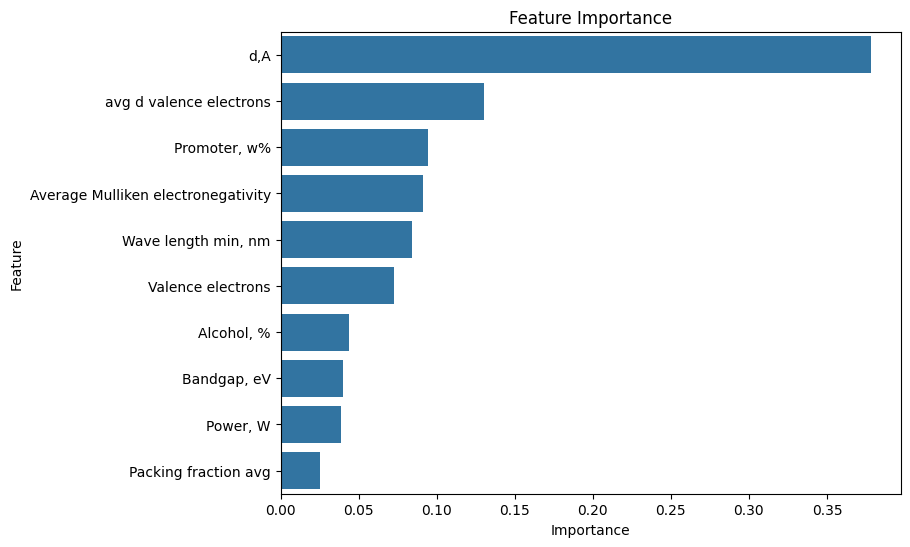

In [420]:
import matplotlib.pyplot as plt

if not(cross_validation):
  feat_imp = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': tree_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(8,6))
  sns.barplot(x='Importance', y='Feature', data=feat_imp)
  plt.title('Feature Importance')
  plt.show()

## Random forest

In [421]:
from sklearn.ensemble import RandomForestRegressor

In [422]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split = 10,
    min_samples_leaf = 1,
    max_features=2,
    random_state=42
)

if(cross_validation):
  scores = cross_val_score(rf_model , X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(rf_model , X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  print('No cross validation')
  rf_model.fit(X_train, y_train)
  train_score = rf_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = rf_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

No cross validation
Train score:  0.7190272137731681


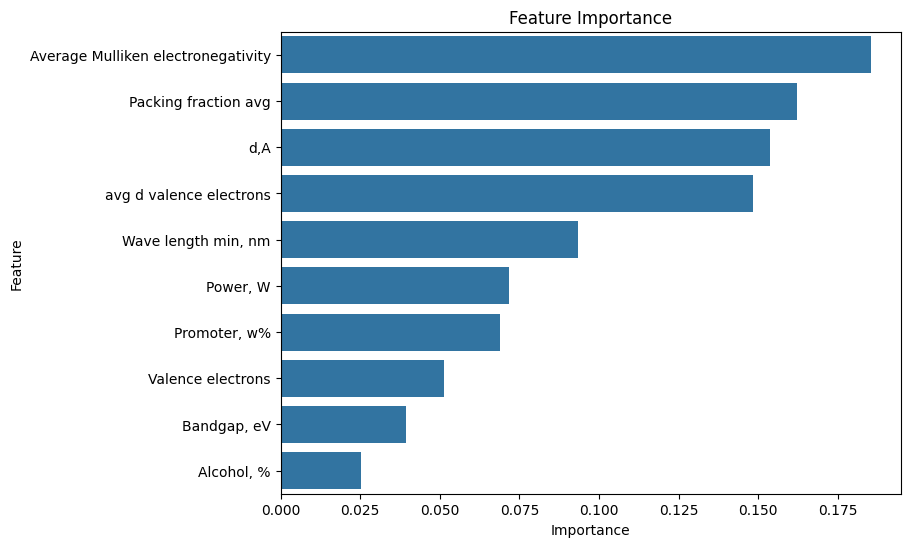

In [423]:
if not(cross_validation):
  feat_imp = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': rf_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(8,6))
  sns.barplot(x='Importance', y='Feature', data=feat_imp)
  plt.title('Feature Importance')
  plt.show()

In [424]:
from sklearn.model_selection import GridSearchCV

if(grid_search):
  param_grid = {
      'n_estimators': [50, 100, 150],
      'max_depth': [4, 5],
      'min_samples_split': [5, 10],
      'min_samples_leaf': [1, 2],
  }
  #Best params {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
  #Best params {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
  #Best params {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

  grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                            param_grid, cv=5, scoring='neg_mean_squared_error')
  grid_search.fit(X_train,y_train)
  print('Best params',grid_search.best_params_)
  print('Best score',grid_search.best_score_)

In [425]:
if(grid_search):
  best_model = grid_search.best_estimator_

  if(cross_validation):
    scores = cross_val_score(best_model , X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", scores)
    print("Mean RMSE:", rmse_scores.mean())

    y_pred = cross_val_predict(best_model , X, y, cv=5)
    draw_actual_predicted(y, y_pred)
  else:
    y_pred = best_model.predict(X_test)
    draw_actual_predicted(y_test, y_pred)

##Gradient boosting

In [426]:
from sklearn.ensemble import GradientBoostingRegressor

In [427]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # number of boosting stages
    learning_rate=0.1,     # shrinkage factor
    max_depth=4,           # depth of each tree
    min_samples_split=6,
    min_samples_leaf=2,
    random_state=42,
    subsample=0.8
)

if(cross_validation):
  scores = cross_val_score(gb_model , X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(gb_model , X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  gb_model.fit(X_train, y_train)
  train_score = gb_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = gb_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

Train score:  0.9127072338892622


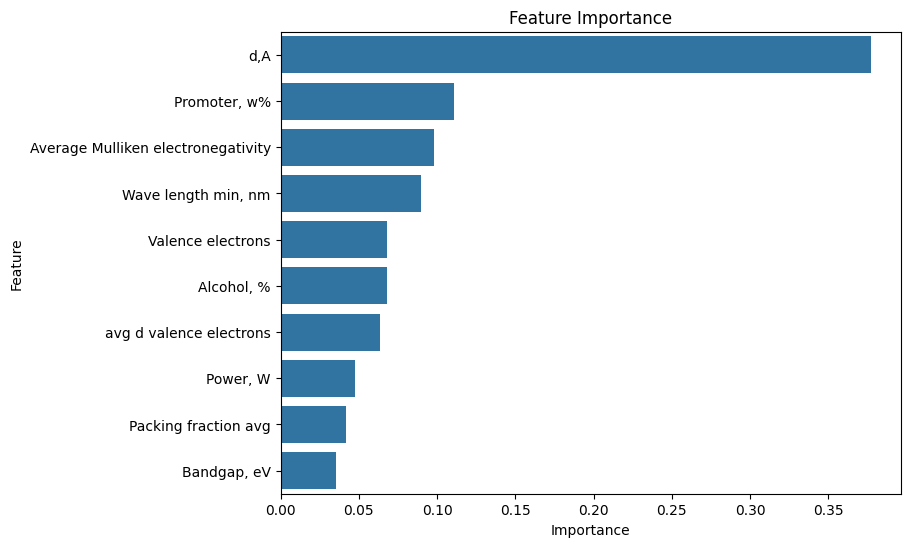

In [428]:
if not(cross_validation):
  feat_imp = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': gb_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(8,6))
  sns.barplot(x='Importance', y='Feature', data=feat_imp)
  plt.title('Feature Importance')
  plt.show()

In [429]:
if(grid_search):
  param_grid = {
      'n_estimators': [100, 150],        # number of boosting stages
      'learning_rate': [0.01, 0.1],   # shrinkage factor
      'max_depth': [3, 4],                # depth of each tree
      'min_samples_split': [4, 6],
      'min_samples_leaf': [1, 2, 3],
      'subsample': [0.8, 1.0]                # fraction of samples for each tree
  }
  #Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100, 'subsample': 0.8}
  #Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100, 'subsample': 0.8}
  #Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 0.8}

  # Grid search with 5-fold cross-validation
  grid_search = GridSearchCV(
      estimator=gb_model,
      param_grid=param_grid,
      cv=5,
      scoring='neg_mean_squared_error',          # or 'neg_mean_squared_error'
      n_jobs=-1,
      verbose=2
  )

  # Fit on training data
  grid_search.fit(X_train, y_train)

  # Best hyperparameters
  print("Best parameters:", grid_search.best_params_)
  print("Best CV RMSE:", grid_search.best_score_)

In [430]:
if(grid_search):
  best_model = grid_search.best_estimator_

  if(cross_validation):
    scores = cross_val_score(best_model , X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", scores)
    print("Mean RMSE:", rmse_scores.mean())

    y_pred = cross_val_predict(best_model , X, y, cv=5)
    draw_actual_predicted(y, y_pred)
  else:
    y_pred = best_model.predict(X_test)
    draw_actual_predicted(y_test, y_pred)

##KNN

In [431]:
from sklearn.neighbors import KNeighborsRegressor

In [432]:
knn_model = KNeighborsRegressor(n_neighbors=20, weights='uniform',p=1)

if(cross_validation):
  scores = cross_val_score(knn_model , X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(knn_model , X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  knn_model.fit(X_train, y_train)
  train_score = knn_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = knn_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

Train score:  0.8653233695111016


In [433]:
if(grid_search):
  param_grid = {
      'n_neighbors': list(range(1, 21)),
      'weights': ['uniform', 'distance'],
      'p': [1, 2]
  }
  #Best parameters: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
  #Best parameters: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
  #Best parameters: {'n_neighbors': 12, 'p': 2, 'weights': 'distance'}

  grid_search = GridSearchCV(
      KNeighborsRegressor(),
      param_grid,
      cv=5,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

  grid_search.fit(X_train,y_train)

  print("Best parameters:", grid_search.best_params_)
  print("Best CV RMSE:", grid_search.best_score_)

In [434]:
if(grid_search):
  best_model = grid_search.best_estimator_

  if(cross_validation):
    scores = cross_val_score(best_model , X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", scores)
    print("Mean RMSE:", rmse_scores.mean())

    y_pred = cross_val_predict(best_model , X, y, cv=5)
    draw_actual_predicted(y, y_pred)
  else:
    y_pred = best_model.predict(X_test)
    draw_actual_predicted(y_test, y_pred)

##Catboost

In [435]:
from catboost import CatBoostRegressor

In [436]:
cat_boost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=4,
    verbose=100
)

if(cross_validation):
  scores = cross_val_score(cat_boost_model , X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(cat_boost_model , X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  cat_boost_model.fit(X_train, y_train)
  train_score = cat_boost_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = cat_boost_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

0:	learn: 3.2900887	total: 1.82ms	remaining: 1.82s
100:	learn: 1.5400726	total: 147ms	remaining: 1.3s
200:	learn: 1.3055056	total: 297ms	remaining: 1.18s
300:	learn: 1.1696830	total: 449ms	remaining: 1.04s
400:	learn: 1.0728502	total: 612ms	remaining: 915ms
500:	learn: 1.0082089	total: 762ms	remaining: 759ms
600:	learn: 0.9576722	total: 914ms	remaining: 607ms
700:	learn: 0.9217192	total: 1.06s	remaining: 454ms
800:	learn: 0.8929217	total: 1.21s	remaining: 301ms
900:	learn: 0.8694748	total: 1.36s	remaining: 150ms
999:	learn: 0.8519251	total: 1.52s	remaining: 0us
Train score:  0.9362665665993521


In [437]:
if not cross_validation:
  #del len
  llen = len(cat_boost_model.feature_importances_)
  feature_dict={}
  for i in range(llen):
    #print(cat_boost_model.feature_names_[i],"   ",cat_boost_model.feature_importances_[i])
    feature_dict[cat_boost_model.feature_names_[i]]=cat_boost_model.feature_importances_[i]
  # print(cat_boost_model.feature_names_[i],"   ",cat_boost_model.feature_importances_[i])

  sorted_dict = dict(
      sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)
  )

  #print(sorted_dict)
  for x,y in sorted_dict.items():
    print(x," ", y)

Average Mulliken electronegativity   16.7255646706559
Wave length min, nm   13.789161024590461
d,A   12.410768928375601
Promoter, w%   12.06381317634817
Valence electrons   8.860804001658982
Power, W   8.780924050088363
Alcohol, %   8.13118591334232
avg d valence electrons   7.3162996686554695
Packing fraction avg   6.192033178411433
Bandgap, eV   5.729445387873306


In [438]:
if(grid_search):
  param_grid = {
      'depth': [4,6],
      'learning_rate':[0.01,0.05,0.1 ]
  }
  #Best parameters: {'depth': 4, 'learning_rate': 0.05}
  #Best parameters: {'depth': 4, 'learning_rate': 0.05}
  #Best parameters: {'depth': 6, 'learning_rate': 0.05}

  grid_search = GridSearchCV(cat_boost_model, param_grid, cv=5,scoring='neg_mean_squared_error',)
  grid_search.fit(X_train,y_train)

  print("Best parameters:", grid_search.best_params_)
  print("Best CV RMSE:", grid_search.best_score_)

In [439]:
if(grid_search):
  est_model = grid_search.best_estimator_

  if(cross_validation):
    print("Cross validation")
    scores = cross_val_score(best_model , X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)

    y_pred = cross_val_predict(best_model , X, y, cv=5)
    draw_actual_predicted(y, y_pred)
    print("Scores: ", scores)
    print("Mean RMSE:", rmse_scores.mean())
  else:
    y_pred = best_model.predict(X_test)
    draw_actual_predicted(y_test, y_pred)

##XGBoost

In [440]:
import xgboost as xgb
from xgboost import XGBRegressor

In [441]:
xgboost_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [442]:
if(cross_validation):
  scores = cross_val_score(xgboost_model , X, y, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(xgboost_model , X, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  xgboost_model.fit(X_train, y_train)
  train_score = xgboost_model.score(X_train, y_train)
  print('Train score: ', train_score)
  y_pred = xgboost_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

Train score:  0.9265747687773217


In [443]:
X_Maliken = X_train[['Average Mulliken electronegativity']]

if(cross_validation):
  cv = KFold(n_splits=5, shuffle=True)
  scores = cross_val_score(linear_model, X_Maliken, y, cv=cv, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print("Scores: ", scores)
  print("Mean RMSE:", rmse_scores.mean())

  y_pred = cross_val_predict(linear_model, X_Maliken, y, cv=5)
  draw_actual_predicted(y, y_pred)
else:
  print('No cross validation')
  linear_model.fit(X_train, y_train)
  y_pred = linear_model.predict(X_test)
  draw_actual_predicted(y_test, y_pred)

No cross validation
